# Instruções
#### objetivo geral: criar uma rede neural para classificação de imagens do dataset fashion mnist e exploração de todas as características da rede neural, uma por vez.
O melhor resultado de cada questão/etapa é utilizado nas próximas 

### QUESTÃO 01: exploração inicial 
- Dataset fashion mnist 
- função de ativação
- 5 testes com inicialização aleatória: diferenças de convergencia, estabilidade e desempenho
- dataset de treino
- métricas: medida de desempenho(accuracy), função de perda (entropia cruzada/loss), curva de convergência
- otimizador: Adam
- arquitetura: quantas camadas e neurônios por camada
- funcoes de ativação: ReLU, Sigmoid ou Tanh
- quantas épocas
- taxa de aprendizado
- indícios de under/overfitting

### QUESTÃO 02: exploração de hiperparâmetros
- taxa de aprendizado x termo momento x velocidade de convergência
- Grid search para encontrar a melhor combinação: erro de treinamento x taxa de aprendizado x momento
- taxa de aprendizado menor e momento intermediário
- dataset de treino e (opcionalmente) dataset de validação
- métricas: função de perda, velocidade de convergência, curva de convergência e (opcional) estabilidade
- critério de parada 
- combinação com melhor equilíbrio entre velocidadee estabilidade
- tendências observadas(ex: maior taxa de aprendizado leva a maior velocidade, mas menor estabilidade)

### QUESTÃO 03: topologia de rede neural
- dataset de treino e (opcionalmente) dataset de validação
- impacto do número de camadas ocultas e neurônios por camada e teste de variação desses números
- métricas: função de perda, curva de convergência(under e overfitting), tempo de treinamento, generalização(medida F), precisão, revocação
- gráfico de perda mostrando diferença entre topologias

### QUESTÃO 04: qualidade dos dados
- influência do número e qualidade dos dados, ruído, etc sobre a capacidade de generalização
- dividir o dataset em subsets de acordo com o rótulo -> manter proporcionalidade
- faixas do dataset: 10%, 30%, 50%, 70%, 100%
- métrica: função de perda, acurácia, 
- identificar saturação no aprendizado
- curvas de generalização: tamanho do conjunto X desempenho
- tempo de treinamento e custo computacional
- Estratégia de amostragem(estratificada, aleatória ou outra)

### QUESTÃO 05:
- escolher 4 melhores modelos e usar modelo de testes neles
- treinamento como referência comparativa
- ajustes de otimização
- métricas: perda(entropia cruzada categórica), acurácia, curva de validação(treinamento x teste), F1 score, precisão, revocação
- escolha da configuração final do modelo

### QUESTÃO 06: validação cruzada k-fold
divisão do dataset em k-subconjuntos e teste em todos eles
- métricas: média de todas as partições de perda: acurácia e F1. 
- para cada partição: curvas de validação e variância(dispersão) dos resultados 
- justificativa do tamanho de k
- identificação de flutuações
---

In [78]:
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow import kerasimpor
from tensorflow import keras
from sklearn.model_selection import train_test_split
import secrets

# Divisão do dataset

In [2]:
#dataset já dividido em treino e teste
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
#split de treino entre 80% treino e 20% validação
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train) #20% do treino vira validação. stratify=Y mantém a proporção das classes
# Normalização (0-1) para visualização e futura modelagem
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0
x_val = x_val.astype("float32")/255.0
"""
converte inteiro discreto de 0 a 255 para contínuo float de 0.0 a 1.0
redes neurais funcionam melhor com entradas contínuas e escala pequena e próxima
float representa melhor valores intermediários entre 2 as cores possíveis (preto e branco)
y é inteiro de 0 a 9, sendo o número sua classe, não precisa de normalização
"""

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'\nconverte inteiro discreto de 0 a 255 para contínuo float de 0.0 a 1.0\nredes neurais funcionam melhor com entradas contínuas e escala pequena e próxima\nfloat representa melhor valores intermediários entre 2 as cores possíveis (preto e branco)\ny é inteiro de 0 a 9, sendo o número sua classe, não precisa de normalização\n'

# vizualização do dataset Fashion-MNIST

Treino: (48000, 28, 28), Validação: (12000, 28, 28), Teste: (10000, 28, 28)
Exemplo de rótulos (0-9): ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


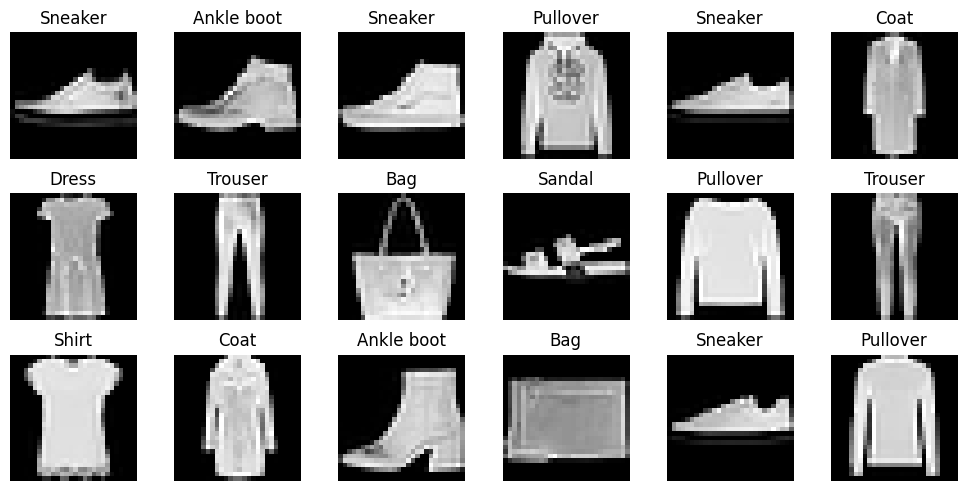

In [3]:
labels = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

print(f"Treino: {x_train.shape}, Validação: {x_val.shape}, Teste: {x_test.shape}")
print("Exemplo de rótulos (0-9):", labels)

# Grid de amostras aleatórias do conjunto de treino
fig, axes = plt.subplots(3, 6, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    idx = np.random.randint(0, len(x_train))
    ax.imshow(x_train[idx], cmap="gray")
    ax.set_title(labels[y_train[idx]])
    ax.axis("off")
plt.tight_layout()
plt.show()

# Questão 01: Rede neural simples

### Modelo

In [4]:
"""
configuração padrão: 
    camada de entrada com 784 neurônios(cada pixel da imagem 28x28)
    2 camadas ocultas (64 e 32 neurônios) 
    camada de saída com 10 neurônios (10 classes)
"""

def build_model(learning_rate=1e-3, beta1=0.9, activation_hidden = 'relu', activation_output = 'softmax', num_hidden_layers=2, neurons_per_layer=[64, 32]):

    layers = [
        keras.layers.InputLayer(shape=(28, 28)),  # imagens 28x28 pixels, cada pixel é um neurônio de entrada
        keras.layers.Flatten()  # transforma matriz 2D 28x28 em vetor 1D com 784 elementos
    ]
    # adiciona dinamicamente as camadas ocultas conforme num_hidden_layers
    for i in range(num_hidden_layers):
        layers.append(keras.layers.Dense(neurons_per_layer[i], activation_hidden))  # ReLU como função de ativação não linear

    # camada de saída
    layers.append(keras.layers.Dense(10, activation_output))  # 10 saídas (classes) possíveis

    # modelo sequencial -> "clássico" com uma camada após a outra
    model = keras.Sequential(layers)

    optimizer = keras.optimizers.Adam(learning_rate, beta1)
    model.compile(
        optimizer = optimizer,  # aprendizado adaptativo
        loss='sparse_categorical_crossentropy',  # ideal para classificação multiclasse com rótulos inteiros
        metrics=['accuracy']  # medida de desempenho simples
    )
    return model


### gerador de seeds

In [5]:
PRIME_STEP = 2654435761  # grande e usado em hashing
MASK32 = 0xFFFFFFFF
base = secrets.randbits(32)

# ===== Método para "espaçar" mais as seeds =====
# Ideia: usar uma base aleatória de 32 bits e aplicar um incremento grande e primo
# (ex: 2654435761 = constante de Knuth) gerando progressão pseudo-dispersada em 32 bits.
# Depois aplicamos uma mistura (hash simples) para minimizar correlação linear.
def spaced_seeds(n, base_seed, step):
    seeds = []
    for i in range(n):
        raw = (base_seed + i * step) & MASK32
        # Mistura extra: multiplicação + xor + shift (barato, evita sequência muito próxima)
        mixed = (raw * 0x9E3779B1) & MASK32
        mixed ^= (mixed >> 16)
        seeds.append(mixed)
    return seeds

seeds = spaced_seeds(5, base, PRIME_STEP)

### treinamento

In [6]:
histories = []
final_metrics = []
log_lines = []

for i, seed in enumerate(seeds, start=1):
    keras.utils.set_random_seed(seed)
    model = build_model()
    h = model.fit(
        x_train, y_train,
        epochs=5,
        batch_size=128,
        verbose=0
    )
    histories.append(h)
    final_metrics.append({
        'run': i,
        'seed': seed,
        'final_train_loss': h.history['loss'][-1],
        'final_train_acc': h.history['accuracy'][-1]
    })
    log_lines.append(
        f"=== Treinamento {i}/5 (seed={seed}) ===\n"
        f"Train - Loss: {h.history['loss'][-1]:.4f}, accuracy: {h.history['accuracy'][-1]:.4f}"
    )

print("\n".join(log_lines))


=== Treinamento 1/5 (seed=738959309) ===
Train - Loss: 0.3444, Acc: 0.8761
=== Treinamento 2/5 (seed=737323989) ===
Train - Loss: 0.3422, Acc: 0.8759
=== Treinamento 3/5 (seed=735668049) ===
Train - Loss: 0.3472, Acc: 0.8738
=== Treinamento 4/5 (seed=734016297) ===
Train - Loss: 0.3423, Acc: 0.8778
=== Treinamento 5/5 (seed=732352236) ===
Train - Loss: 0.3447, Acc: 0.8775


### gráficos

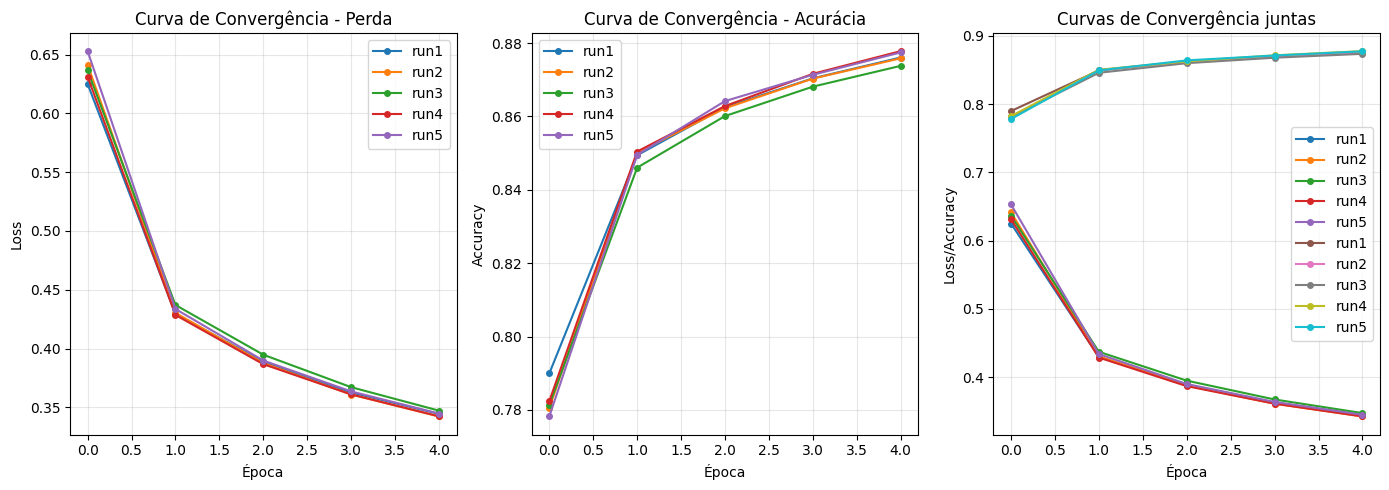


========== ESTABILIDADE ==========
Loss - média: 0.3442
Loss - desvio padrão: 0.0018
Acc  - média: 0.8762
Acc  - desvio padrão: 0.0014


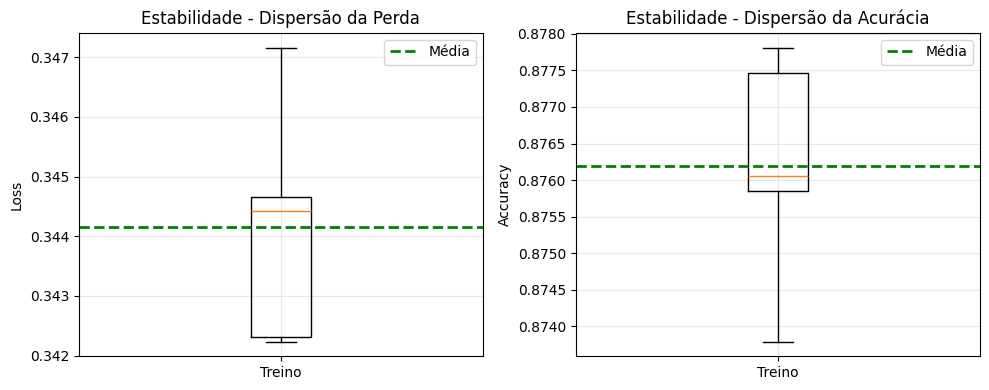


========== DESEMPENHO por seed ==========
Run 1 (seed=738959309): Loss=0.3444, Acc=0.8761
Run 2 (seed=737323989): Loss=0.3422, Acc=0.8759
Run 3 (seed=735668049): Loss=0.3472, Acc=0.8738
Run 4 (seed=734016297): Loss=0.3423, Acc=0.8778
Run 5 (seed=732352236): Loss=0.3447, Acc=0.8775


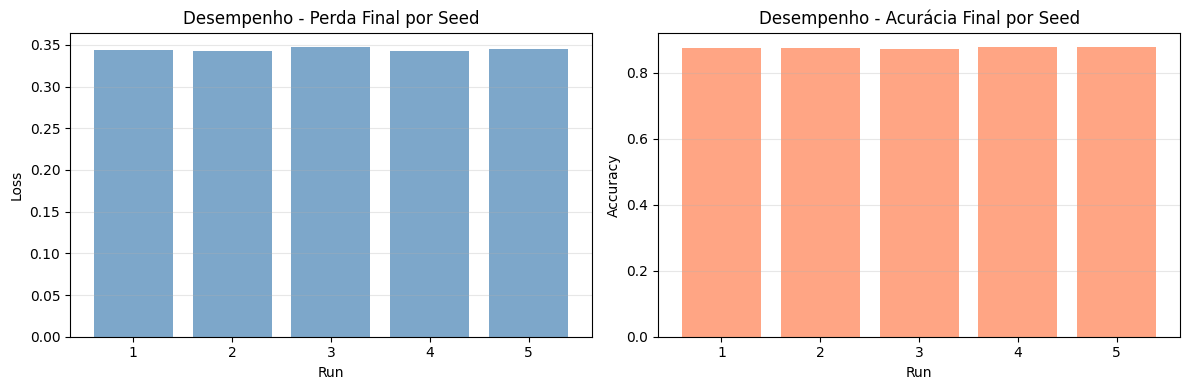


Seeds usadas: [738959309, 737323989, 735668049, 734016297, 732352236]


In [7]:
# ========== CURVAS DE CONVERGÊNCIA ==========
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

#perda
for i, h in enumerate(histories, start=1):
    axes[0].plot(h.history['loss'], label=f'run{i}', marker='o', markersize=4)
axes[0].set_title('Curva de Convergência - Perda')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

#acurácia
for i, h in enumerate(histories, start=1):
    axes[1].plot(h.history['accuracy'], label=f'run{i}', marker='o', markersize=4)
axes[1].set_title('Curva de Convergência - Acurácia')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

#as duas(análise de over/underfitting)
for i, h in enumerate(histories, start=1):
    axes[2].plot(h.history['loss'], label=f'run{i}', marker='o', markersize=4)
for i, h in enumerate(histories, start=1):
    axes[2].plot(h.history['accuracy'], label=f'run{i}', marker='o', markersize=4)
axes[2].set_title('Curvas de Convergência juntas')
axes[2].set_xlabel('Época')
axes[2].set_ylabel('Loss/Accuracy')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
#loss continua alta, accuracy continua baixa -> underfitting
#loss continua caindo mesmo com accuracy estagnada -> overfitting
# ========== ESTABILIDADE ==========
train_losses = [m['final_train_loss'] for m in final_metrics]
train_accuracies = [m['final_train_acc'] for m in final_metrics]

print("\n========== ESTABILIDADE ==========")
print(f"Loss - média: {np.mean(train_losses):.4f}")
print(f"Loss - desvio padrão: {np.std(train_losses):.4f}")
print(f"accuracy  - média: {np.mean(train_accuracies):.4f}")
print(f"accuracy  - desvio padrão: {np.std(train_accuracies):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
#5 seeds divididas entre bigode superior(máximo), limite superior da caixa, linha laranja (mediana), limite inferior da caixa, bigode inferior(mínimo)
axes[0].boxplot(train_losses, whis=(0, 100))
axes[0].set_title('Estabilidade - Dispersão da Perda')
axes[0].set_ylabel('Loss')
axes[0].set_xticklabels(['Treino'])
#axes[0].scatter([1]*len(train_losses), train_losses, color='red', zorder=2)
axes[0].axhline(y=np.mean(train_losses), color='green', linestyle='--', linewidth=2, label='Média')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(train_accuracies, whis=(0, 100))
axes[1].set_title('Estabilidade - Dispersão da Acurácia')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticklabels(['Treino'])
#axes[1].scatter([1]*len(train_accuracies), train_accuracies, color='red', zorder=2)
axes[1].axhline(y=np.mean(train_accuracies), color='green', linestyle='--', linewidth=2, label='Média')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== DESEMPENHO ==========
print("\n========== DESEMPENHO por seed ==========")
for m in final_metrics:
    print(f"Run {m['run']} (seed={m['seed']}): Loss={m['final_train_loss']:.4f}, accuracy={m['final_train_acc']:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
x = np.arange(1, 6)

axes[0].bar(x, train_losses, alpha=0.7, color='steelblue')
axes[0].set_title('Desempenho - Perda Final por Seed')
axes[0].set_xlabel('Run')
axes[0].set_ylabel('Loss')
axes[0].set_xticks(x)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(x, train_accuracies, alpha=0.7, color='coral')
axes[1].set_title('Desempenho - Acurácia Final por Seed')
axes[1].set_xlabel('Run')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(x)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nSeeds usadas:", seeds)

### escolha de função de ativação

In [88]:
activation_function_hidden_layer_options = ['relu', 'sigmoid', 'tanh']

### treinamento

In [89]:
#TODO
#TODO
seeds_q1 = spaced_seeds(1, base, PRIME_STEP)
results_q1 = []  

for activation_function_hidden_layer in activation_function_hidden_layer_options:
    run_losses = []
    run_accuracies = []
    
    for s in seeds_q1:
        keras.utils.set_random_seed(s)
        model = build_model(activation_hidden=activation_function_hidden_layer)
        h = model.fit(x_train, y_train, verbose=1)
        run_losses.append(h.history['loss'][-1])
        run_accuracies.append(h.history['accuracy'][-1])
    results_q1.append({
        'activation_function_hidden_layer': activation_function_hidden_layer,
        'loss_mean': float(np.mean(run_losses)),
        'loss_std': float(np.std(run_losses)),
        'accuracy_mean': float(np.mean(run_accuracies)),
        'accuracy_std': float(np.std(run_accuracies))
    })

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7570 - loss: 0.7193
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7570 - loss: 0.7193
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6547 - loss: 1.2376
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6547 - loss: 1.2376
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7722 - loss: 0.6911
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7722 - loss: 0.6911


### ordenação

In [91]:
# Ordena por melhor equilíbrio: alta acurácia média, baixa perda média e baixa variância
# Score simples: accuracy_mean - loss_mean - (loss_std + accuracy_std)
sorted_results_q1 = sorted(
    results_q1,
    key=lambda sorted_result: (-(sorted_result['accuracy_mean']), sorted_result['loss_mean'], sorted_result['loss_std'] + sorted_result['accuracy_std'])
)

print("Funções de ativação(melhor pra pior):")
for i,sorted_result in enumerate(sorted_results_q1[:3]):
    print(
        f"{i+1}. activation_function_hidden_layer={sorted_result['activation_function_hidden_layer']}"
    )

Funções de ativação(melhor pra pior):
1. activation_function_hidden_layer=tanh
2. activation_function_hidden_layer=relu
3. activation_function_hidden_layer=sigmoid


# Questão 02: hiperparâmetros

### parâmetros ajustados

In [ ]:
#TODO: mais opcões de hiperparâmetros para teste exaustivo final
num_epochs_grid = [5, 10, 20]
learning_rates = [1e-4, 1e-3, 1e-2]
batch_sizes = [64, 128, 256]
momentums_beta1 = [0.7, 0.9, 0.99]

### treinamento

In [92]:
#TODO: aumentar número de seeds para teste exaustivo final
#TODO: treino e validação
import time

seeds_q2 = spaced_seeds(1, base, PRIME_STEP)
results_q2 = []  # lista de dicts com hiperparâmetros e métricas agregadas
histories_q2 = []

for epochs in num_epochs_grid:
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            for beta1 in momentums_beta1:
                run_losses = []
                run_accuracies = []
                run_times = []
                
                for s in seeds_q2:
                    keras.utils.set_random_seed(s)
                    model = build_model(learning_rate=learning_rate, beta1=beta1)
                    
                    # Mede tempo de treinamento
                    start_time = time.time()
                    h = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
                    training_time = time.time() - start_time
                    
                    histories_q2.append(h)
                    run_losses.append(h.history['loss'][-1])
                    run_accuracies.append(h.history['accuracy'][-1])
                    run_times.append(training_time)
                    
                results_q2.append({
                    'epochs': epochs,
                    'learning_rate': learning_rate,
                    'batch_size': batch_size,
                    'beta1': beta1,
                    'loss_mean': float(np.mean(run_losses)),
                    'loss_std': float(np.std(run_losses)),
                    'accuracy_mean': float(np.mean(run_accuracies)),
                    'accuracy_std': float(np.std(run_accuracies)),
                    'time_mean': float(np.mean(run_times)),
                    'time_std': float(np.std(run_times))
                })

print(f"\n✓ Treinamento Q2 concluído: {len(results_q2)} combinações testadas")

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5784 - loss: 1.3966
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5784 - loss: 1.3966
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8068 - loss: 0.5962
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8068 - loss: 0.5962
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8279 - loss: 0.5112
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8279 - loss: 0.5112
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8394 - loss: 0.4725
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8394 - loss: 0.4725
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8461 - loss: 0.4481
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8461 - loss: 0.4481
Epoch 1/5
Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5700 - loss: 1.4105
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.

### ordenação

In [43]:
# Ordena por melhor equilíbrio: alta acurácia média, baixa perda média e baixa variância
# Score simples: accuracy_mean - loss_mean - (loss_std + accuracy_std)
sorted_results_q2 = sorted(
    results_q2,
    key=lambda sorted_result: (-(sorted_result['accuracy_mean']), sorted_result['loss_mean'], sorted_result['loss_std'] + sorted_result['accuracy_std'])
)

print("Top 10 melhores combinações (melhor pro pior):")
for i,sorted_result in enumerate(sorted_results_q2[:10]):
    print(
        f"{i+1}. epochs={sorted_result['epochs']}, learning_rate={sorted_result['learning_rate']},"
        f" batch={sorted_result['batch_size']}, beta1={sorted_result['beta1']} | "
        f"loss_mean={sorted_result['loss_mean']:.4f} (±{sorted_result['loss_std']:.4f}), "
        f"accuracy_mean={sorted_result['accuracy_mean']:.4f} (±{sorted_result['accuracy_std']:.4f})"
    )

print("\n\nTop 10 piores combinações (melhor pro pior):")
for i,sorted_result in enumerate(sorted_results_q2[-10:-1]):
    print(
        f"{i+1}. epochs={sorted_result['epochs']}, learning_rate={sorted_result['learning_rate']},"
        f" batch={sorted_result['batch_size']}, beta1={sorted_result['beta1']} | "
        f"loss_mean={sorted_result['loss_mean']:.4f} (±{sorted_result['loss_std']:.4f}), "
        f"accuracy_mean={sorted_result['accuracy_mean']:.4f} (±{sorted_result['accuracy_std']:.4f})"
    )

Top 10 melhores combinações (melhor pro pior):
1. epochs=20, learning_rate=0.001, batch=64, beta1=0.7 | loss_mean=0.2011 (±0.0000), accuracy_mean=0.9252 (±0.0000)
2. epochs=20, learning_rate=0.001, batch=64, beta1=0.9 | loss_mean=0.2078 (±0.0000), accuracy_mean=0.9237 (±0.0000)
3. epochs=20, learning_rate=0.001, batch=128, beta1=0.7 | loss_mean=0.2185 (±0.0000), accuracy_mean=0.9201 (±0.0000)
4. epochs=20, learning_rate=0.001, batch=128, beta1=0.9 | loss_mean=0.2271 (±0.0000), accuracy_mean=0.9165 (±0.0000)
5. epochs=20, learning_rate=0.001, batch=256, beta1=0.9 | loss_mean=0.2425 (±0.0000), accuracy_mean=0.9129 (±0.0000)
6. epochs=20, learning_rate=0.001, batch=256, beta1=0.7 | loss_mean=0.2436 (±0.0000), accuracy_mean=0.9123 (±0.0000)
7. epochs=20, learning_rate=0.001, batch=64, beta1=0.99 | loss_mean=0.2415 (±0.0000), accuracy_mean=0.9110 (±0.0000)
8. epochs=20, learning_rate=0.001, batch=128, beta1=0.99 | loss_mean=0.2477 (±0.0000), accuracy_mean=0.9090 (±0.0000)
9. epochs=20, lear

### comparações

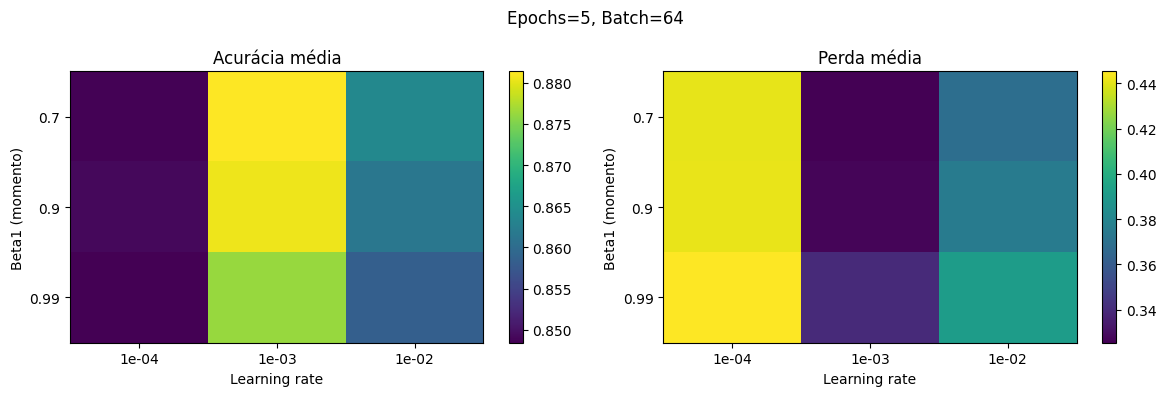

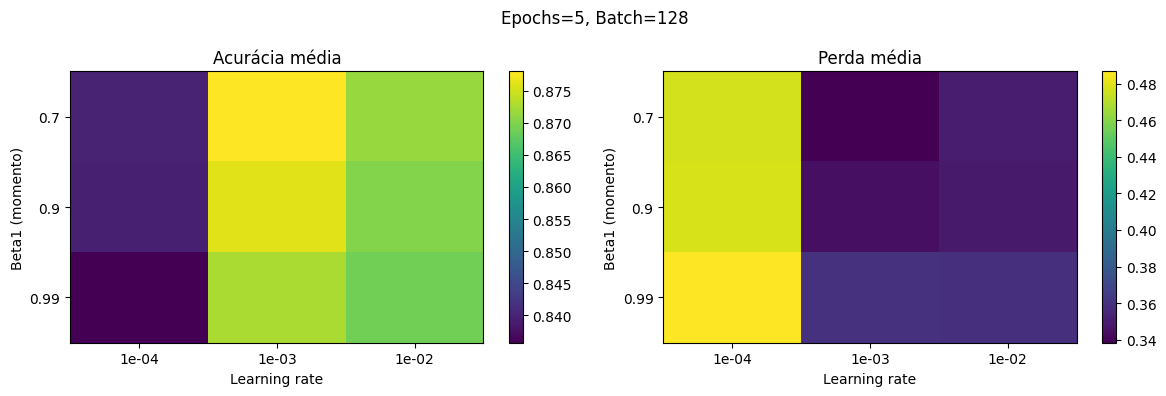

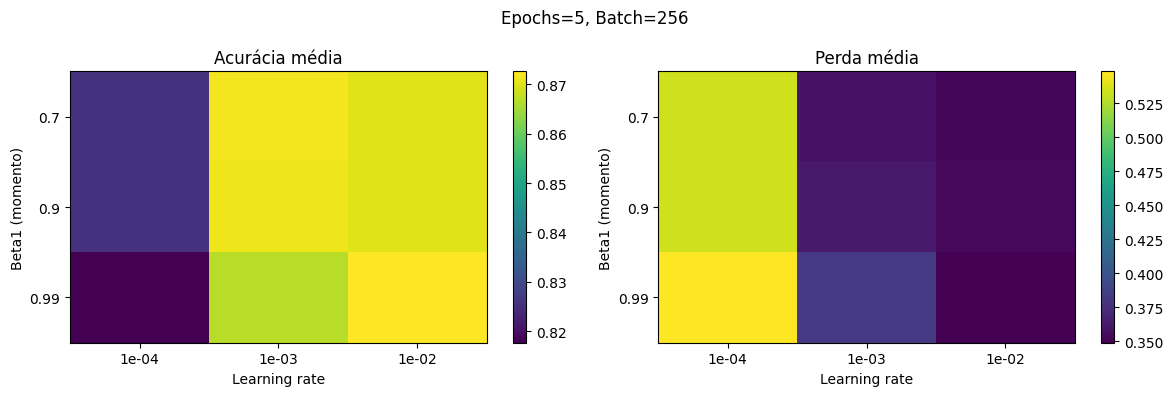

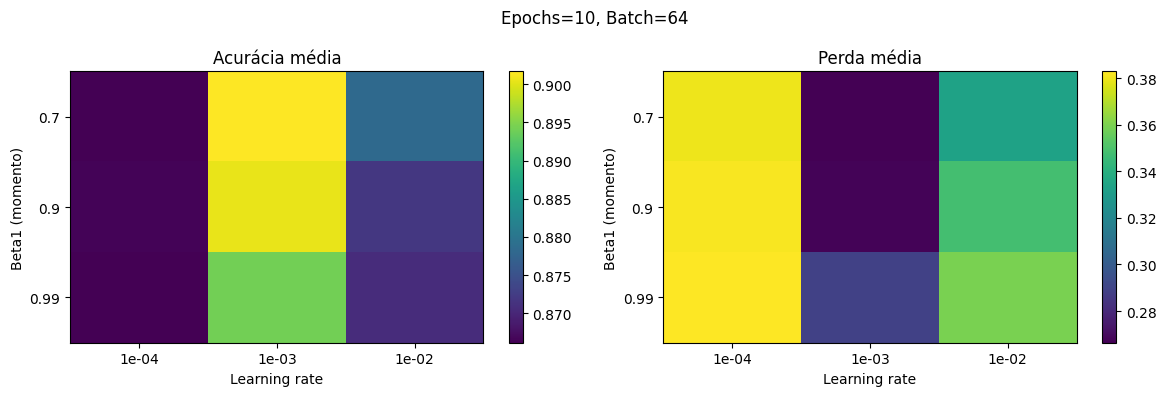

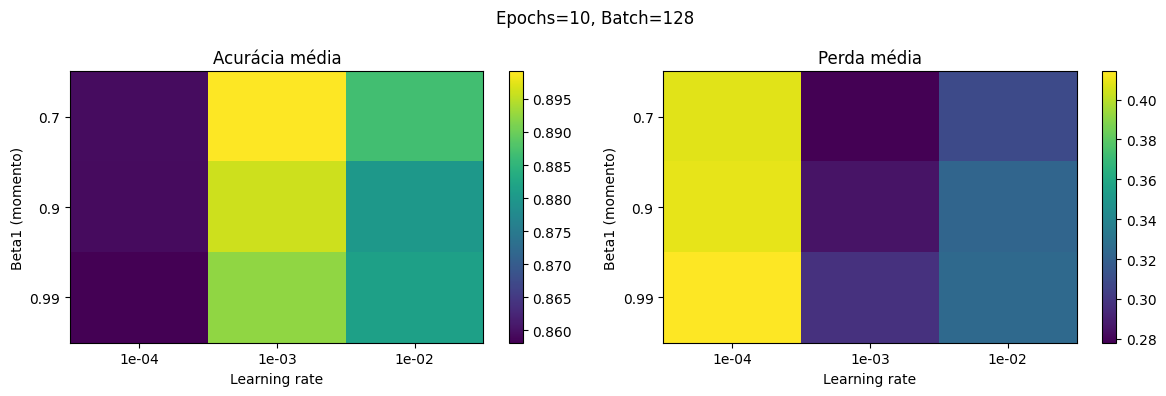

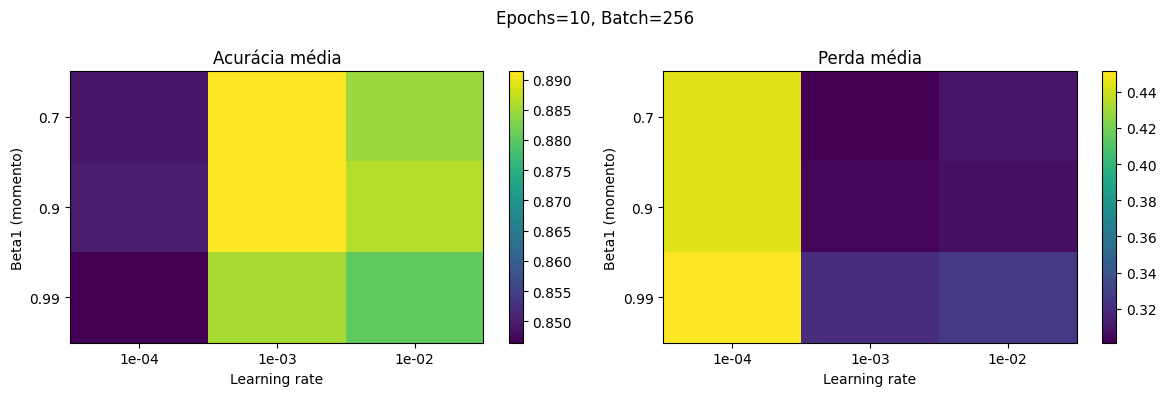

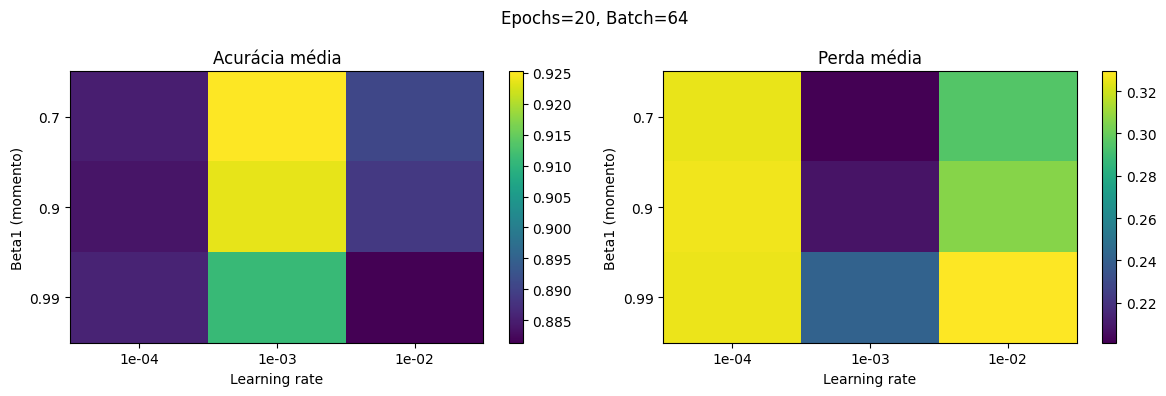

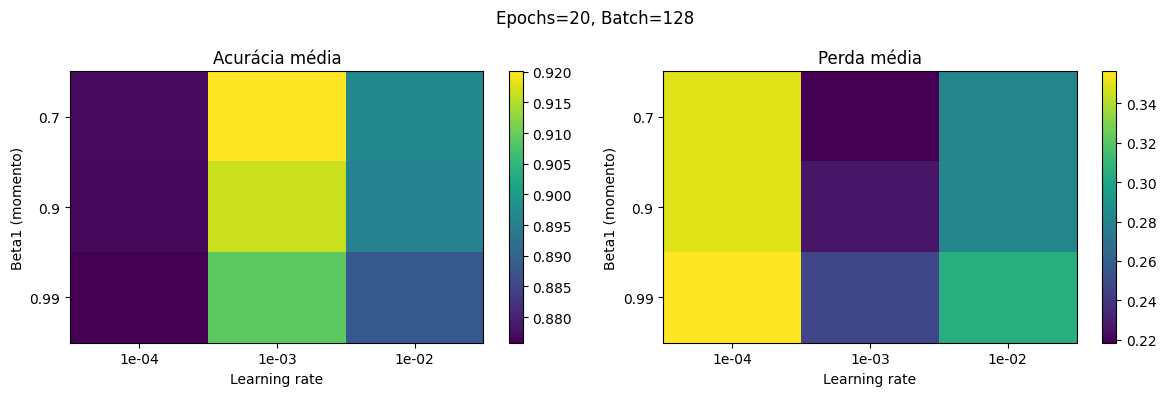

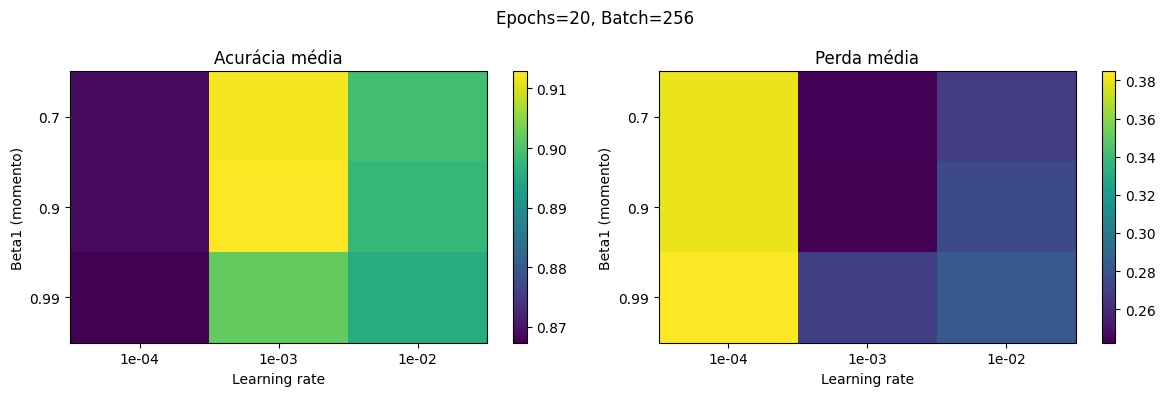

In [39]:
# Loop sobre epochs e batch_size: para cada combinação, gera mapas de calor 2D (beta1 x learning_rate)
# usando as métricas agregadas em `results`.

# Conjuntos ordenados de parâmetros disponíveis em `results`
unique_epochs = sorted(list({r['epochs'] for r in results_q2}))
unique_batch_sizes = sorted(list({r['batch_size'] for r in results_q2}))
unique_beta1s = sorted(list({r['beta1'] for r in results_q2}))
unique_learning_rates = sorted(list({r['learning_rate'] for r in results_q2}))

# Para cada (epochs, batch_size), monta matrizes 2D [beta1 x lr] de acurácia e perda
for epochs in unique_epochs:
    for batch_size in unique_batch_sizes:
        # Filtra resultados referentes à combinação fixa (epochs, batch_size)
        subset = [r for r in results_q2 if r['epochs'] == epochs and r['batch_size'] == batch_size]
        if not subset:
            continue
        # Índices para mapeamento beta1 x lr
        b1_index = {b1: i for i, b1 in enumerate(unique_beta1s)}
        lr_index = {lr: j for j, lr in enumerate(unique_learning_rates)}

        accuracy_matrix = np.full((len(unique_beta1s), len(unique_learning_rates)), np.nan)
        loss_matrix = np.full((len(unique_beta1s), len(unique_learning_rates)), np.nan)

        for r in subset:
            i = b1_index[r['beta1']]
            j = lr_index[r['learning_rate']]
            accuracy_matrix[i, j] = r['accuracy_mean']
            loss_matrix[i, j] = r['loss_mean']

        # Visualização dos mapas de calor
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"Epochs={epochs}, Batch={batch_size}")

        im0 = axes[0].imshow(accuracy_matrix, cmap='viridis', aspect='auto')
        axes[0].set_title('Acurácia média')
        axes[0].set_xticks(range(len(unique_learning_rates)))
        axes[0].set_xticklabels([f"{lr:.0e}" for lr in unique_learning_rates])
        axes[0].set_yticks(range(len(unique_beta1s)))
        axes[0].set_yticklabels([str(b1) for b1 in unique_beta1s])
        axes[0].set_xlabel('Learning rate')
        axes[0].set_ylabel('Beta1 (momento)')
        plt.colorbar(im0, ax=axes[0])

        im1 = axes[1].imshow(loss_matrix, cmap='viridis', aspect='auto')
        axes[1].set_title('Perda média')
        axes[1].set_xticks(range(len(unique_learning_rates)))
        axes[1].set_xticklabels([f"{lr:.0e}" for lr in unique_learning_rates])
        axes[1].set_yticks(range(len(unique_beta1s)))
        axes[1].set_yticklabels([str(b1) for b1 in unique_beta1s])
        axes[1].set_xlabel('Learning rate')
        axes[1].set_ylabel('Beta1 (momento)')
        plt.colorbar(im1, ax=axes[1])

        plt.tight_layout()
        plt.show()
#esperado: loss com cores invertidas de accuracy -> equilibrados

### visualização alternativa

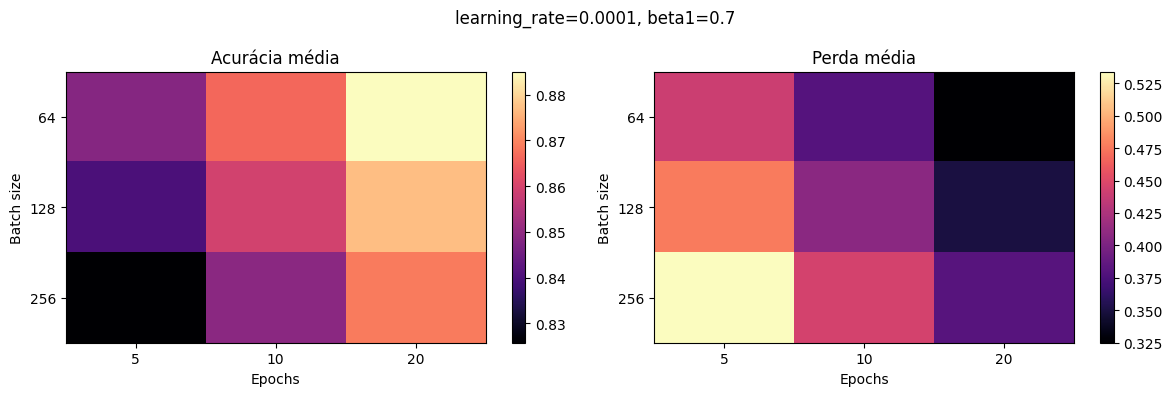

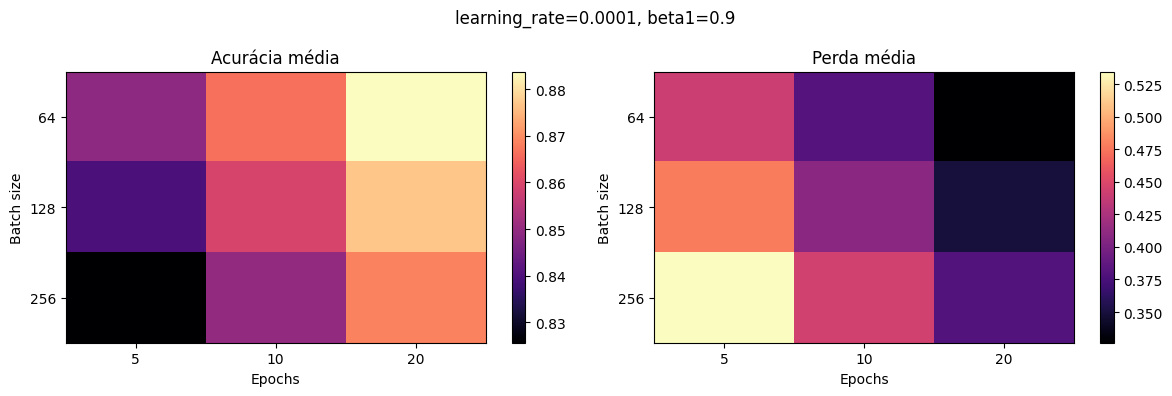

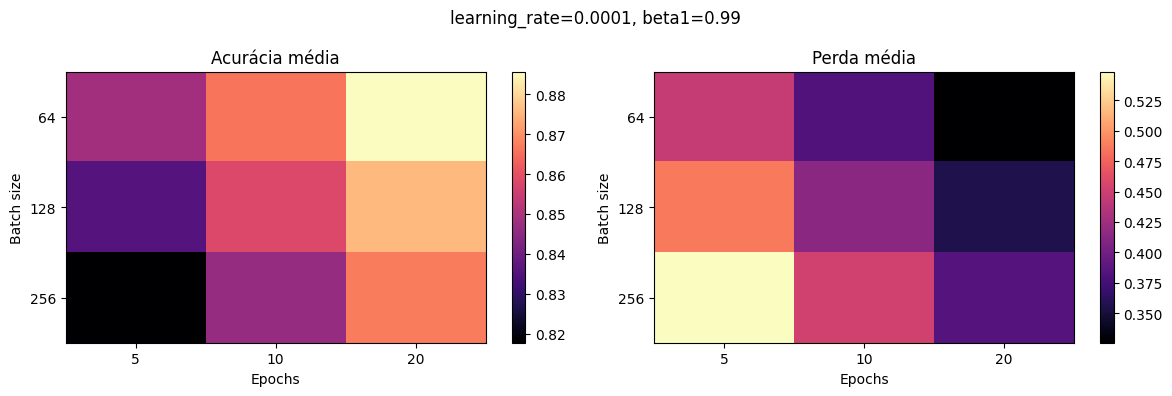

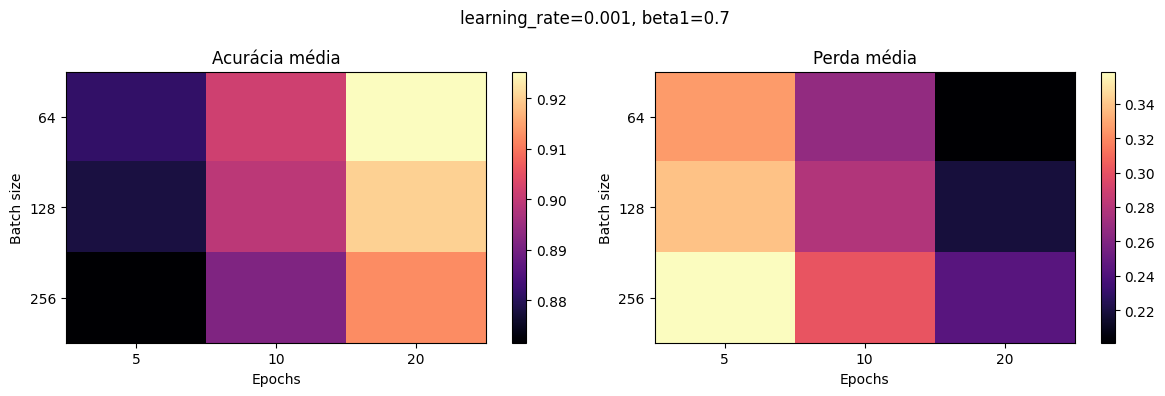

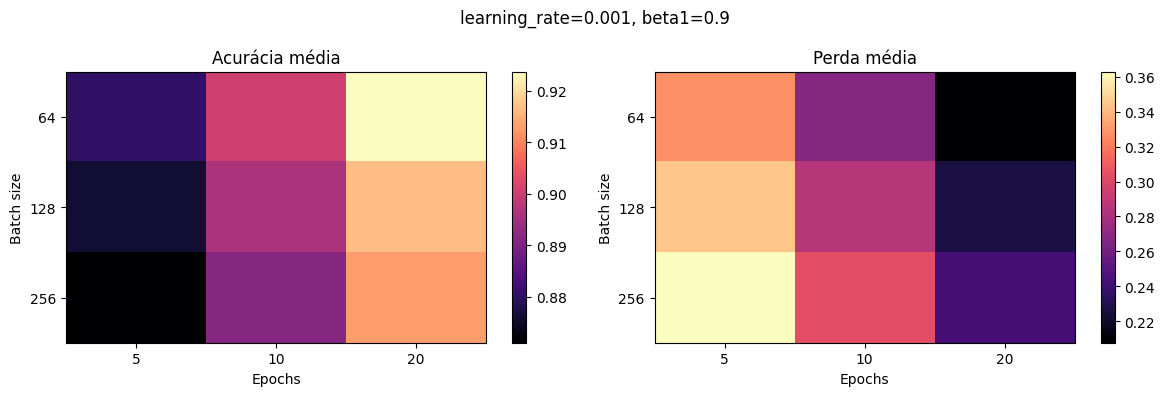

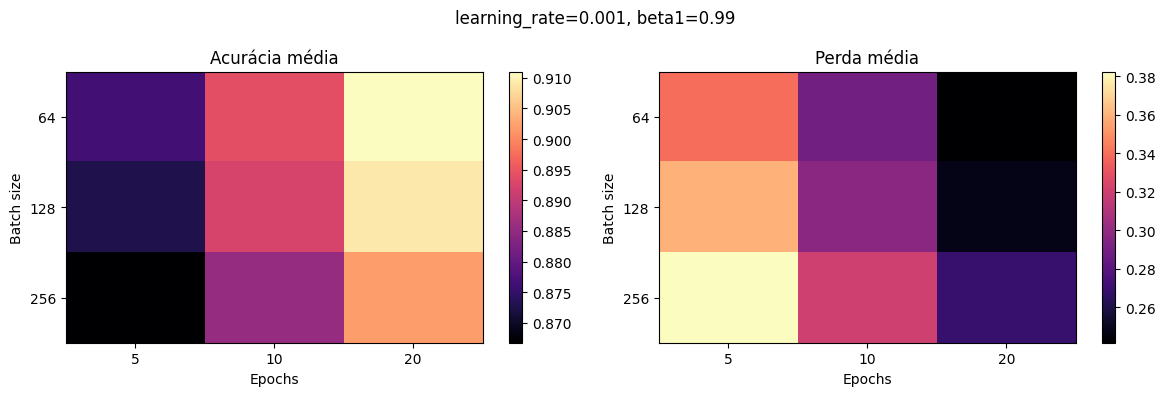

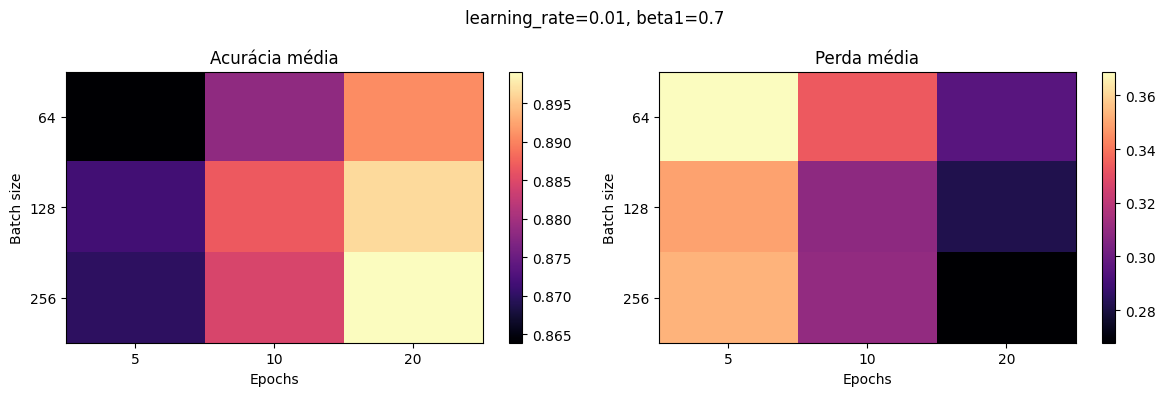

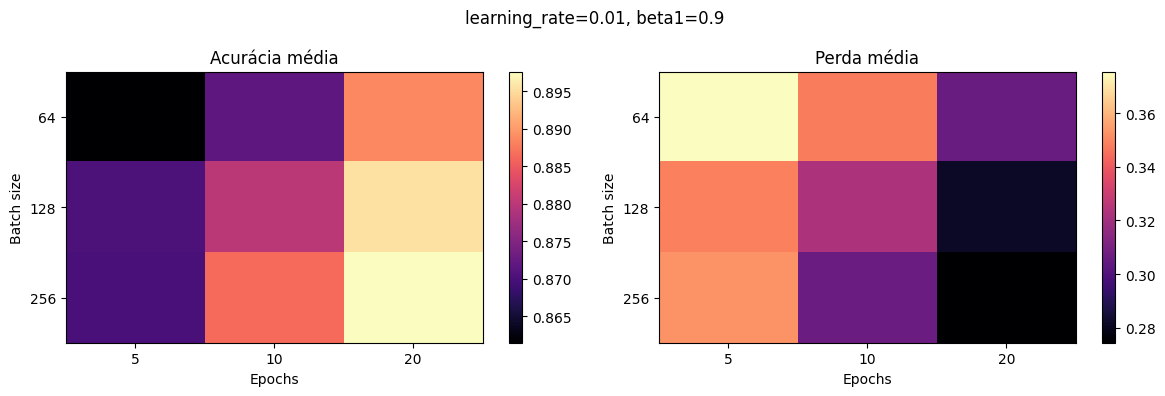

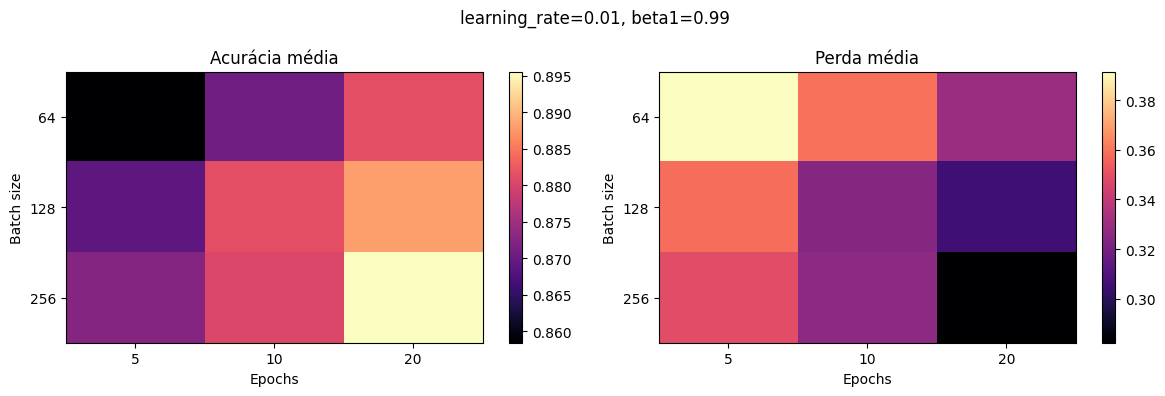

In [42]:
# Para cada (lr, beta1), monta matrizes 2D [epoch x batch_size] de acurácia e perda
for learning_rate in unique_learning_rates:
    for beta1 in unique_beta1s:
        # Filtra resultados referentes à combinação fixa (epochs, batch_size)
        subset = [r for r in results_q2 if r['learning_rate'] == learning_rate and r['beta1'] == beta1]
        if not subset:
            continue
        # Índices para mapeamento beta1 x lr
        ba_index = {ba: i for i, ba in enumerate(unique_batch_sizes)}
        ep_index = {ep: j for j, ep in enumerate(unique_epochs)}

        accuracy_matrix = np.full((len(unique_batch_sizes), len(unique_epochs)), np.nan)
        loss_matrix = np.full((len(unique_batch_sizes), len(unique_epochs)), np.nan)

        for r in subset:
            i = ba_index[r['batch_size']]
            j = ep_index[r['epochs']]
            accuracy_matrix[i, j] = r['accuracy_mean']
            loss_matrix[i, j] = r['loss_mean']

        # Visualização dos mapas de calor
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"learning_rate={learning_rate}, beta1={beta1}")

        im0 = axes[0].imshow(accuracy_matrix, cmap='magma', aspect='auto')
        axes[0].set_title('Acurácia média')
        axes[0].set_xticks(range(len(unique_epochs)))
        axes[0].set_xticklabels([str(ep) for ep in unique_epochs])
        axes[0].set_yticks(range(len(unique_batch_sizes)))
        axes[0].set_yticklabels([str(b) for b in unique_batch_sizes])
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Batch size')
        plt.colorbar(im0, ax=axes[0])

        im1 = axes[1].imshow(loss_matrix, cmap='magma', aspect='auto')
        axes[1].set_title('Perda média')
        axes[1].set_xticks(range(len(unique_epochs)))
        axes[1].set_xticklabels([str(ep) for ep in unique_epochs])
        axes[1].set_yticks(range(len(unique_batch_sizes)))
        axes[1].set_yticklabels([str(b) for b in unique_batch_sizes])
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Batch size')
        plt.colorbar(im1, ax=axes[1])

        plt.tight_layout()
        plt.show()

### métricas

========== MÉTRICAS Q2 - Análise de Convergência ==========

Total de históricos coletados: 81
Total de combinações testadas: 81


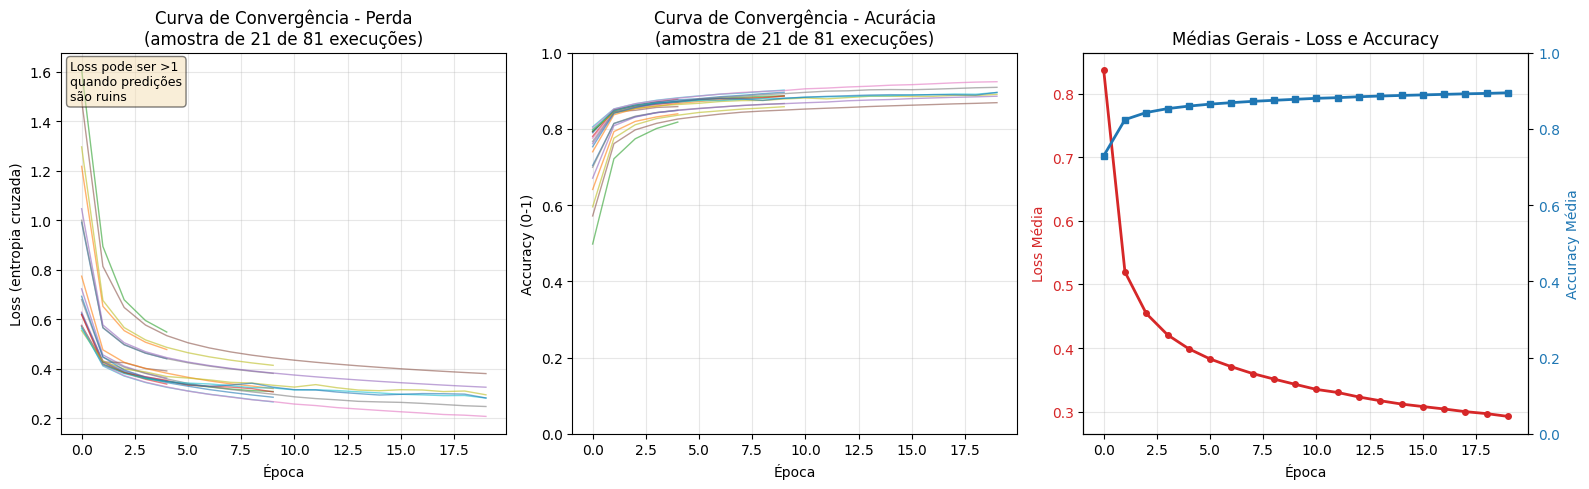


========== ESTABILIDADE (n=81) ==========
Loss - média: 0.3449, desvio: 0.0735
Loss - mín: 0.2011, máx: 0.5486
Accuracy - média: 0.8773, desvio: 0.0223
Accuracy - mín: 0.8177, máx: 0.9252


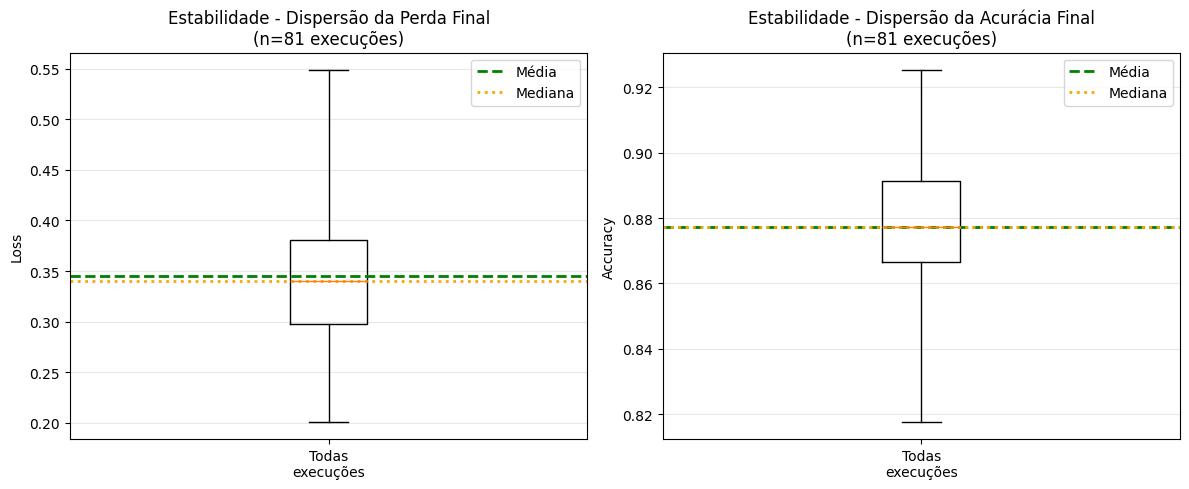


========== DISTRIBUIÇÃO DAS MÉTRICAS FINAIS ==========


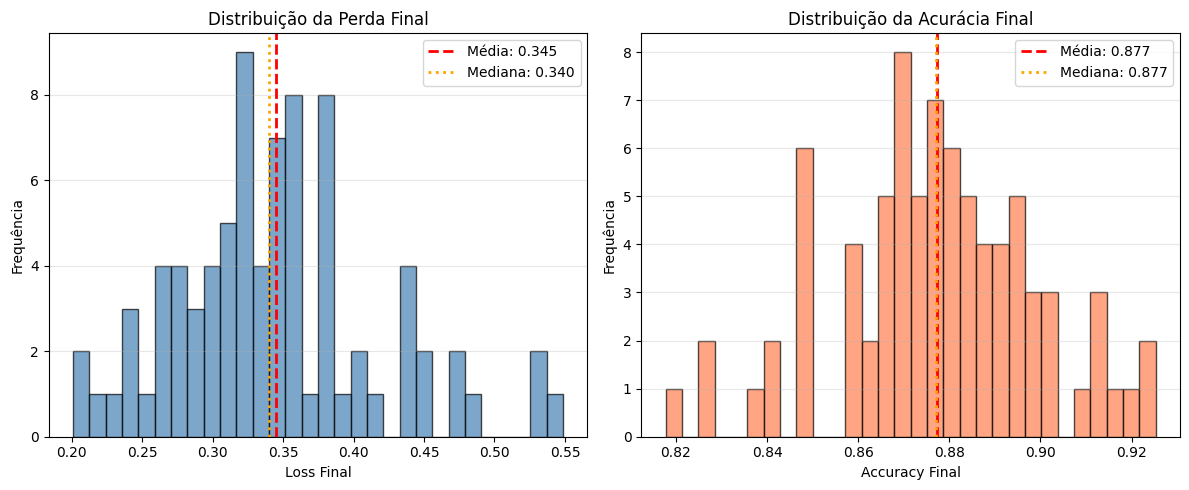


========== TEMPO DE TREINAMENTO ==========
Tempo médio geral: 25.20s (±16.97s)
Tempo mínimo: 6.36s
Tempo máximo: 66.66s

Tempo médio por número de épocas:
  5 épocas: 11.18s (±3.79s)
  10 épocas: 21.50s (±7.80s)
  20 épocas: 42.92s (±16.28s)


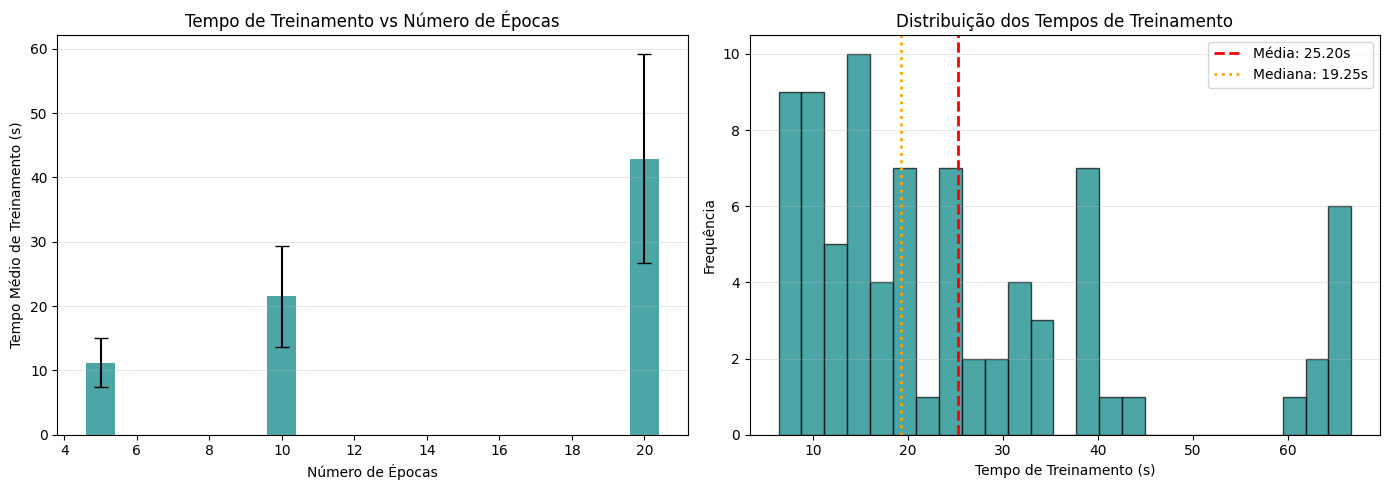


========== TOP 5 COMBINAÇÕES MAIS RÁPIDAS ==========
1. Tempo: 6.36s | epochs=5, lr=0.0001, batch=256, beta1=0.9
   Loss: 0.5345, Acc: 0.8256
2. Tempo: 6.38s | epochs=5, lr=0.001, batch=256, beta1=0.9
   Loss: 0.3629, Acc: 0.8711
3. Tempo: 6.49s | epochs=5, lr=0.01, batch=256, beta1=0.7
   Loss: 0.3528, Acc: 0.8699
4. Tempo: 7.17s | epochs=5, lr=0.01, batch=256, beta1=0.99
   Loss: 0.3490, Acc: 0.8726
5. Tempo: 7.63s | epochs=5, lr=0.001, batch=256, beta1=0.99
   Loss: 0.3824, Acc: 0.8668

========== TOP 5 COMBINAÇÕES MAIS LENTAS ==========
1. Tempo: 65.22s | epochs=20, lr=0.001, batch=64, beta1=0.7
   Loss: 0.2011, Acc: 0.9252
2. Tempo: 65.31s | epochs=20, lr=0.0001, batch=64, beta1=0.9
   Loss: 0.3265, Acc: 0.8838
3. Tempo: 65.37s | epochs=20, lr=0.001, batch=64, beta1=0.99
   Loss: 0.2415, Acc: 0.9110
4. Tempo: 65.90s | epochs=20, lr=0.0001, batch=64, beta1=0.7
   Loss: 0.3249, Acc: 0.8850
5. Tempo: 66.66s | epochs=20, lr=0.0001, batch=64, beta1=0.99
   Loss: 0.3257, Acc: 0.8857

✓

In [93]:
# Métricas da Questão 02: função de perda, curvas de convergência, estabilidade, velocidade de convergência e tempo
# Usa os dados já coletados em histories_q2 e results_q2

# NOTA: A perda (entropia cruzada categórica) pode ser > 1 quando o modelo faz predições ruins.
# Loss = -log(p), onde p é a probabilidade da classe correta.
# Se p=0.1, loss=-log(0.1)≈2.3; se p=0.01, loss≈4.6

print("========== MÉTRICAS Q2 - Análise de Convergência ==========\n")
print(f"Total de históricos coletados: {len(histories_q2)}")
print(f"Total de combinações testadas: {len(results_q2)}")

# ========== CURVAS DE CONVERGÊNCIA ==========
# Seleciona apenas alguns históricos para visualização clara (evita poluição)
sample_step = max(1, len(histories_q2) // 20)  # Mostra ~20 linhas
sample_indices = list(range(0, len(histories_q2), sample_step))

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

#perda
for idx in sample_indices:
    h = histories_q2[idx]
    axes[0].plot(h.history['loss'], alpha=0.6, linewidth=1)
axes[0].set_title(f'Curva de Convergência - Perda\n(amostra de {len(sample_indices)} de {len(histories_q2)} execuções)')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss (entropia cruzada)')
axes[0].grid(True, alpha=0.3)
axes[0].text(0.02, 0.98, 'Loss pode ser >1\nquando predições\nsão ruins', 
             transform=axes[0].transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

#acurácia
for idx in sample_indices:
    h = histories_q2[idx]
    axes[1].plot(h.history['accuracy'], alpha=0.6, linewidth=1)
axes[1].set_title(f'Curva de Convergência - Acurácia\n(amostra de {len(sample_indices)} de {len(histories_q2)} execuções)')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy (0-1)')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

#as duas (média geral)
# Calcula médias para visualização mais limpa
max_epochs = max(len(h.history['loss']) for h in histories_q2)
avg_loss_by_epoch = []
avg_acc_by_epoch = []

for epoch in range(max_epochs):
    losses_at_epoch = [h.history['loss'][epoch] for h in histories_q2 if len(h.history['loss']) > epoch]
    accs_at_epoch = [h.history['accuracy'][epoch] for h in histories_q2 if len(h.history['accuracy']) > epoch]
    avg_loss_by_epoch.append(np.mean(losses_at_epoch))
    avg_acc_by_epoch.append(np.mean(accs_at_epoch))

ax2 = axes[2]
color_loss = 'tab:red'
ax2.set_xlabel('Época')
ax2.set_ylabel('Loss Média', color=color_loss)
ax2.plot(range(max_epochs), avg_loss_by_epoch, color=color_loss, linewidth=2, marker='o', markersize=4, label='Loss média')
ax2.tick_params(axis='y', labelcolor=color_loss)
ax2.grid(True, alpha=0.3)

ax2_twin = ax2.twinx()
color_acc = 'tab:blue'
ax2_twin.set_ylabel('Accuracy Média', color=color_acc)
ax2_twin.plot(range(max_epochs), avg_acc_by_epoch, color=color_acc, linewidth=2, marker='s', markersize=4, label='Acc média')
ax2_twin.tick_params(axis='y', labelcolor=color_acc)
ax2_twin.set_ylim([0, 1])

axes[2].set_title('Médias Gerais - Loss e Accuracy')

plt.tight_layout()
plt.show()

# ========== ESTABILIDADE ==========
train_losses = [h.history['loss'][-1] for h in histories_q2]
train_accuracies = [h.history['accuracy'][-1] for h in histories_q2]

print(f"\n========== ESTABILIDADE (n={len(train_losses)}) ==========")
print(f"Loss - média: {np.mean(train_losses):.4f}, desvio: {np.std(train_losses):.4f}")
print(f"Loss - mín: {np.min(train_losses):.4f}, máx: {np.max(train_losses):.4f}")
print(f"Accuracy - média: {np.mean(train_accuracies):.4f}, desvio: {np.std(train_accuracies):.4f}")
print(f"Accuracy - mín: {np.min(train_accuracies):.4f}, máx: {np.max(train_accuracies):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot de Loss
axes[0].boxplot(train_losses, whis=(0, 100))
axes[0].set_title(f'Estabilidade - Dispersão da Perda Final\n(n={len(train_losses)} execuções)')
axes[0].set_ylabel('Loss')
axes[0].set_xticklabels(['Todas\nexecuções'])
axes[0].axhline(y=np.mean(train_losses), color='green', linestyle='--', linewidth=2, label='Média')
axes[0].axhline(y=np.median(train_losses), color='orange', linestyle=':', linewidth=2, label='Mediana')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Boxplot de Accuracy
axes[1].boxplot(train_accuracies, whis=(0, 100))
axes[1].set_title(f'Estabilidade - Dispersão da Acurácia Final\n(n={len(train_accuracies)} execuções)')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticklabels(['Todas\nexecuções'])
axes[1].axhline(y=np.mean(train_accuracies), color='green', linestyle='--', linewidth=2, label='Média')
axes[1].axhline(y=np.median(train_accuracies), color='orange', linestyle=':', linewidth=2, label='Mediana')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ========== DISTRIBUIÇÃO DAS MÉTRICAS FINAIS ==========
print("\n========== DISTRIBUIÇÃO DAS MÉTRICAS FINAIS ==========")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histograma de Loss
axes[0].hist(train_losses, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(np.mean(train_losses), color='red', linestyle='--', linewidth=2, label=f'Média: {np.mean(train_losses):.3f}')
axes[0].axvline(np.median(train_losses), color='orange', linestyle=':', linewidth=2, label=f'Mediana: {np.median(train_losses):.3f}')
axes[0].set_xlabel('Loss Final')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição da Perda Final')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Histograma de Accuracy
axes[1].hist(train_accuracies, bins=30, alpha=0.7, color='coral', edgecolor='black')
axes[1].axvline(np.mean(train_accuracies), color='red', linestyle='--', linewidth=2, label=f'Média: {np.mean(train_accuracies):.3f}')
axes[1].axvline(np.median(train_accuracies), color='orange', linestyle=':', linewidth=2, label=f'Mediana: {np.median(train_accuracies):.3f}')
axes[1].set_xlabel('Accuracy Final')
axes[1].set_ylabel('Frequência')
axes[1].set_title('Distribuição da Acurácia Final')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ========== TEMPO DE TREINAMENTO ==========
print("\n========== TEMPO DE TREINAMENTO ==========")

# Extrai tempos de todas as combinações
all_times = [r['time_mean'] for r in results_q2]
all_time_stds = [r['time_std'] for r in results_q2]

print(f"Tempo médio geral: {np.mean(all_times):.2f}s (±{np.std(all_times):.2f}s)")
print(f"Tempo mínimo: {np.min(all_times):.2f}s")
print(f"Tempo máximo: {np.max(all_times):.2f}s")

# Analisa tempo por número de épocas
time_by_epochs = {}
for r in results_q2:
    ep = r['epochs']
    if ep not in time_by_epochs:
        time_by_epochs[ep] = []
    time_by_epochs[ep].append(r['time_mean'])

print("\nTempo médio por número de épocas:")
for ep in sorted(time_by_epochs.keys()):
    times = time_by_epochs[ep]
    print(f"  {ep} épocas: {np.mean(times):.2f}s (±{np.std(times):.2f}s)")

# Gráfico de tempo por épocas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_list = sorted(time_by_epochs.keys())
mean_times = [np.mean(time_by_epochs[ep]) for ep in epochs_list]
std_times = [np.std(time_by_epochs[ep]) for ep in epochs_list]

axes[0].bar(epochs_list, mean_times, yerr=std_times, alpha=0.7, capsize=5, color='teal')
axes[0].set_xlabel('Número de Épocas')
axes[0].set_ylabel('Tempo Médio de Treinamento (s)')
axes[0].set_title('Tempo de Treinamento vs Número de Épocas')
axes[0].grid(True, alpha=0.3, axis='y')

# Distribuição de todos os tempos
axes[1].hist(all_times, bins=25, alpha=0.7, color='teal', edgecolor='black')
axes[1].axvline(np.mean(all_times), color='red', linestyle='--', linewidth=2, label=f'Média: {np.mean(all_times):.2f}s')
axes[1].axvline(np.median(all_times), color='orange', linestyle=':', linewidth=2, label=f'Mediana: {np.median(all_times):.2f}s')
axes[1].set_xlabel('Tempo de Treinamento (s)')
axes[1].set_ylabel('Frequência')
axes[1].set_title('Distribuição dos Tempos de Treinamento')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ========== TOP 5 MAIS RÁPIDAS ==========
print("\n========== TOP 5 COMBINAÇÕES MAIS RÁPIDAS ==========")
sorted_by_time = sorted(results_q2, key=lambda x: x['time_mean'])
for i, r in enumerate(sorted_by_time[:5], 1):
    print(f"{i}. Tempo: {r['time_mean']:.2f}s | epochs={r['epochs']}, lr={r['learning_rate']}, "
          f"batch={r['batch_size']}, beta1={r['beta1']}")
    print(f"   Loss: {r['loss_mean']:.4f}, Acc: {r['accuracy_mean']:.4f}")

print("\n========== TOP 5 COMBINAÇÕES MAIS LENTAS ==========")
for i, r in enumerate(sorted_by_time[-5:], 1):
    print(f"{i}. Tempo: {r['time_mean']:.2f}s | epochs={r['epochs']}, lr={r['learning_rate']}, "
          f"batch={r['batch_size']}, beta1={r['beta1']}")
    print(f"   Loss: {r['loss_mean']:.4f}, Acc: {r['accuracy_mean']:.4f}")

print("\n✓ Análise completa das métricas Q2 concluída")

# Questão 03: topologia

### Parâmetros ajustados

In [32]:
num_hidden_layers_options = [1, 2, 3]
neurons_per_layer_options = {
    1: [[64], [128], [256]],
    2: [[64, 32], [128, 64], [256, 128]],
    3: [[128, 64, 32], [256, 128, 64], [512, 256, 128]]
}

### treinamento

In [83]:
#TODO: aumentar número de seeds para teste exaustivo final
#TODO: treino e validação
import time
from sklearn.metrics import f1_score, precision_score, recall_score

seeds_q3 = spaced_seeds(1, base, PRIME_STEP)
results_q3 = []  # lista de dicts com hiperparâmetros e métricas agregadas
histories_q3 = []  # armazena históricos completos para análise de convergência

for num_hidden_layers in num_hidden_layers_options:
    for neurons_per_layer in neurons_per_layer_options[num_hidden_layers]:
        run_losses = []
        run_accuracies = []
        run_times = []
        run_f1_scores = []
        run_precisions = []
        run_recalls = []
        
        for s in seeds_q3:
            keras.utils.set_random_seed(s)
            model = build_model(learning_rate=0.001, beta1=0.7, num_hidden_layers=num_hidden_layers, neurons_per_layer=neurons_per_layer)
            
            # Mede tempo de treinamento
            start_time = time.time()
            h = model.fit(x_train, y_train, epochs=20, batch_size=64, verbose=0)
            training_time = time.time() - start_time
            
            # Faz predições no conjunto de treino para calcular métricas
            y_pred = model.predict(x_train, verbose=0)
            y_pred_classes = np.argmax(y_pred, axis=1)
            
            # Calcula métricas de classificação
            f1 = f1_score(y_train, y_pred_classes, average='weighted')
            precision = precision_score(y_train, y_pred_classes, average='weighted', zero_division=0)
            recall = recall_score(y_train, y_pred_classes, average='weighted')
            
            run_losses.append(h.history['loss'][-1])
            run_accuracies.append(h.history['accuracy'][-1])
            run_times.append(training_time)
            run_f1_scores.append(f1)
            run_precisions.append(precision)
            run_recalls.append(recall)
            histories_q3.append({
                'history': h,
                'num_hidden_layers': num_hidden_layers,
                'neurons_per_layer': neurons_per_layer
            })
            
        results_q3.append({
            'number of hidden layers': num_hidden_layers,
            'neurons per layer': neurons_per_layer,
            'loss_mean': float(np.mean(run_losses)),
            'loss_std': float(np.std(run_losses)),
            'accuracy_mean': float(np.mean(run_accuracies)),
            'accuracy_std': float(np.std(run_accuracies)),
            'time_mean': float(np.mean(run_times)),
            'time_std': float(np.std(run_times)),
            'f1_mean': float(np.mean(run_f1_scores)),
            'f1_std': float(np.std(run_f1_scores)),
            'precision_mean': float(np.mean(run_precisions)),
            'precision_std': float(np.std(run_precisions)),
            'recall_mean': float(np.mean(run_recalls)),
            'recall_std': float(np.std(run_recalls))
        })
        
print(f"\n✓ Treinamento Q3 concluído: {len(results_q3)} configurações testadas")


✓ Treinamento Q3 concluído: 9 configurações testadas


### Ordenação

In [85]:
# Ordena por melhor equilíbrio: alta acurácia média, baixa perda média e baixa variância
# Score simples: accuracy_mean - loss_mean - (loss_std + accuracy_std)
#9 combinações possíveis
sorted_results_q3 = sorted(
    results_q3,
    key=lambda sorted_result_q3: (-(sorted_result_q3['accuracy_mean']), sorted_result_q3['loss_mean'], sorted_result_q3['loss_std'] + sorted_result_q3['accuracy_std'])
)

print("Top combinações (melhor primeiro):")
for i,sorted_result_q3 in enumerate(sorted_results_q3[:8]):
    print(
        f"{i+1}. number of hidden layers={sorted_result_q3['number of hidden layers']}"
        f" neurons per layer={sorted_result_q3['neurons per layer']}"
    )

Top combinações (melhor primeiro):
1. number of hidden layers=2 neurons per layer=[256, 128]
2. number of hidden layers=1 neurons per layer=[256]
3. number of hidden layers=3 neurons per layer=[512, 256, 128]
4. number of hidden layers=3 neurons per layer=[256, 128, 64]
5. number of hidden layers=2 neurons per layer=[128, 64]
6. number of hidden layers=1 neurons per layer=[128]
7. number of hidden layers=3 neurons per layer=[128, 64, 32]
8. number of hidden layers=2 neurons per layer=[64, 32]


### comparação

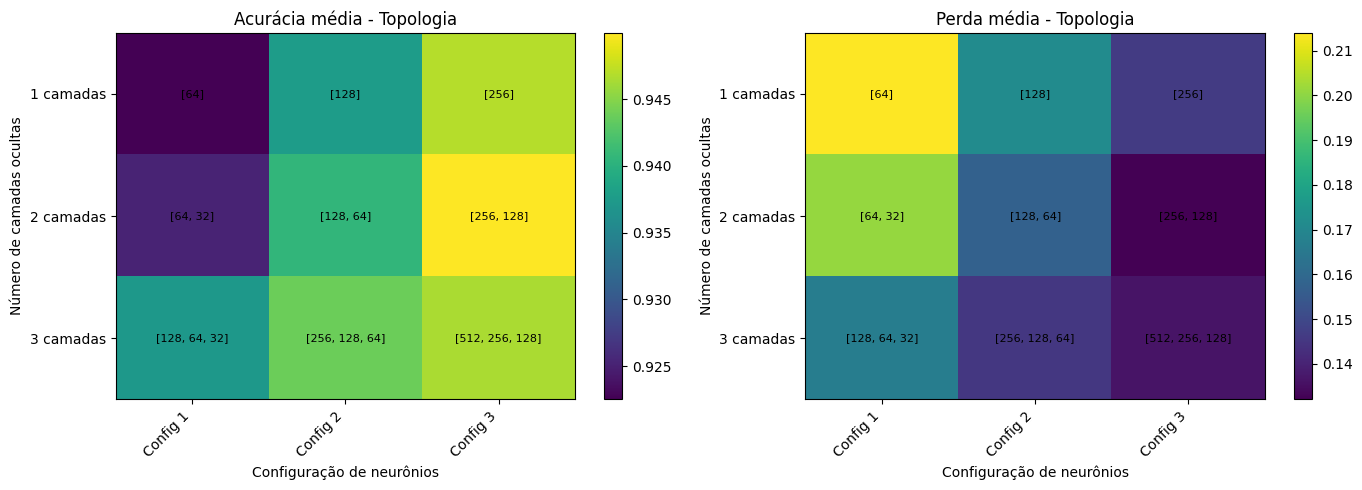

In [86]:
# Mapa de calor: número de camadas ocultas X neurônios por camada
# Cada combinação de (num_hidden_layers, neurons_per_layer) é mapeada para uma célula do heatmap

# Conjuntos ordenados de parâmetros disponíveis em `results_q3`
unique_num_hidden_layers = sorted(list({r['number of hidden layers'] for r in results_q3}))

# Para cada número de camadas, ordena as configurações de neurônios
# Como temos 3 opções por número de camadas, indexamos sequencialmente
configs_per_layers = {nh: [] for nh in unique_num_hidden_layers}
for r in results_q3:
    nh = r['number of hidden layers']
    nn = r['neurons per layer']
    if nn not in configs_per_layers[nh]:
        configs_per_layers[nh].append(nn)

# Ordena cada lista por tamanho crescente (soma de neurônios)
for nh in configs_per_layers:
    configs_per_layers[nh].sort(key=lambda x: sum(x))

# Número máximo de configurações por número de camadas
max_configs = max(len(configs_per_layers[nh]) for nh in unique_num_hidden_layers)

# Matrizes: linhas = número de camadas, colunas = configurações de neurônios
accuracy_matrix = np.full((len(unique_num_hidden_layers), max_configs), np.nan)
loss_matrix = np.full((len(unique_num_hidden_layers), max_configs), np.nan)

# Preenche as matrizes
for i, nh in enumerate(unique_num_hidden_layers):
    for j, nn in enumerate(configs_per_layers[nh]):
        # Encontra o resultado correspondente
        match = [r for r in results_q3 if r['number of hidden layers'] == nh and r['neurons per layer'] == nn]
        if match:
            accuracy_matrix[i, j] = match[0]['accuracy_mean']
            loss_matrix[i, j] = match[0]['loss_mean']

# Labels das colunas (configurações de neurônios)
col_labels = []
for nh in unique_num_hidden_layers:
    for nn in configs_per_layers[nh]:
        col_labels.append(str(nn))

# Como as configurações variam por linha, criamos labels genéricos
# e anotaremos nos ticks
config_labels = [f"Config {j+1}" for j in range(max_configs)]

# Visualização dos mapas de calor
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im0 = axes[0].imshow(accuracy_matrix, cmap='viridis', aspect='auto')
axes[0].set_title('Acurácia média - Topologia')
axes[0].set_xticks(range(max_configs))
axes[0].set_xticklabels(config_labels, rotation=45, ha='right')
axes[0].set_yticks(range(len(unique_num_hidden_layers)))
axes[0].set_yticklabels([f"{nh} camadas" for nh in unique_num_hidden_layers])
axes[0].set_xlabel('Configuração de neurônios')
axes[0].set_ylabel('Número de camadas ocultas')

# Anota cada célula com a configuração real
for i, nh in enumerate(unique_num_hidden_layers):
    for j, nn in enumerate(configs_per_layers[nh]):
        text = axes[0].text(j, i, str(nn), ha="center", va="center", 
                           color="white" if accuracy_matrix[i, j] < 0.5 else "black",
                           fontsize=8)

plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(loss_matrix, cmap='viridis', aspect='auto')
axes[1].set_title('Perda média - Topologia')
axes[1].set_xticks(range(max_configs))
axes[1].set_xticklabels(config_labels, rotation=45, ha='right')
axes[1].set_yticks(range(len(unique_num_hidden_layers)))
axes[1].set_yticklabels([f"{nh} camadas" for nh in unique_num_hidden_layers])
axes[1].set_xlabel('Configuração de neurônios')
axes[1].set_ylabel('Número de camadas ocultas')

# Anota cada célula com a configuração real
for i, nh in enumerate(unique_num_hidden_layers):
    for j, nn in enumerate(configs_per_layers[nh]):
        text = axes[1].text(j, i, str(nn), ha="center", va="center",
                           color="white" if loss_matrix[i, j] > 0.5 else "black",
                           fontsize=8)

plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


### Métricas

========== ANÁLISE DE TODAS AS TOPOLOGIAS Q3 ==========

1. FUNÇÃO DE PERDA - Todas as configurações


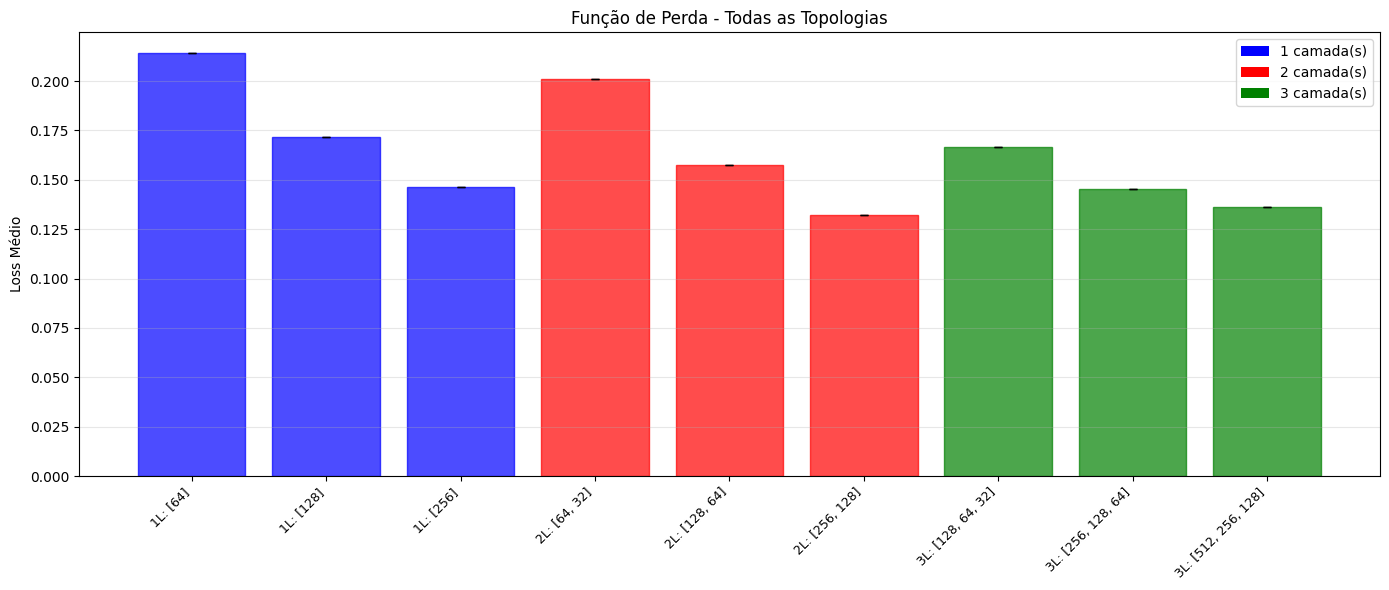


1 camada(s):
  [64]: Loss = 0.2140 (±0.0000)
  [128]: Loss = 0.1717 (±0.0000)
  [256]: Loss = 0.1463 (±0.0000)

2 camada(s):
  [64, 32]: Loss = 0.2011 (±0.0000)
  [128, 64]: Loss = 0.1576 (±0.0000)
  [256, 128]: Loss = 0.1320 (±0.0000)

3 camada(s):
  [128, 64, 32]: Loss = 0.1668 (±0.0000)
  [256, 128, 64]: Loss = 0.1454 (±0.0000)
  [512, 256, 128]: Loss = 0.1363 (±0.0000)

2. CURVAS DE CONVERGÊNCIA - Análise de Under/Overfitting


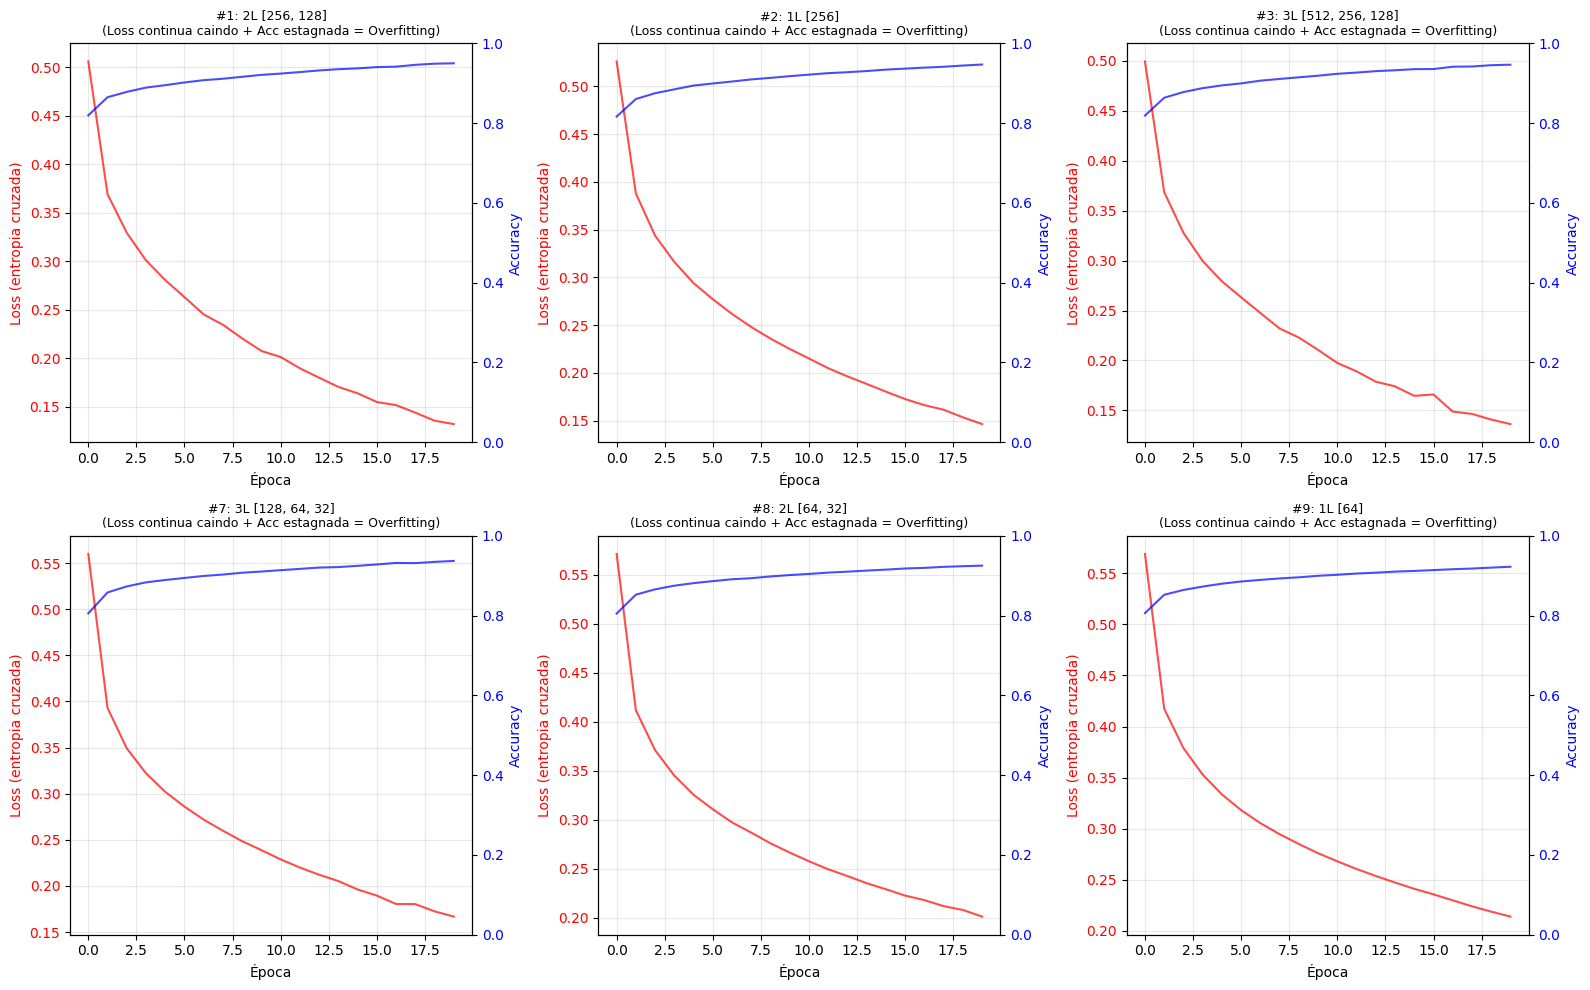


3. TEMPO DE TREINAMENTO


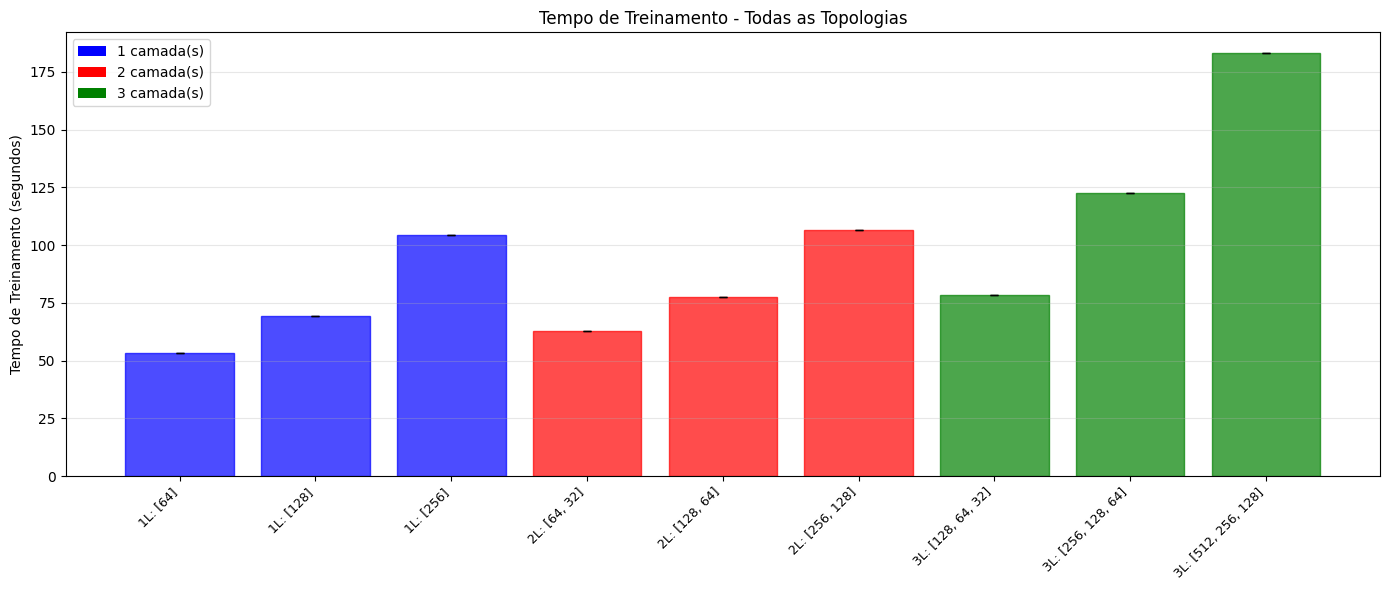


1 camada(s):
  [64]: Tempo = 53.09s (±0.00s)
  [128]: Tempo = 69.38s (±0.00s)
  [256]: Tempo = 104.51s (±0.00s)

2 camada(s):
  [64, 32]: Tempo = 62.71s (±0.00s)
  [128, 64]: Tempo = 77.63s (±0.00s)
  [256, 128]: Tempo = 106.38s (±0.00s)

3 camada(s):
  [128, 64, 32]: Tempo = 78.59s (±0.00s)
  [256, 128, 64]: Tempo = 122.38s (±0.00s)
  [512, 256, 128]: Tempo = 183.02s (±0.00s)

4. GENERALIZAÇÃO - Medida F1, Precisão e Revocação


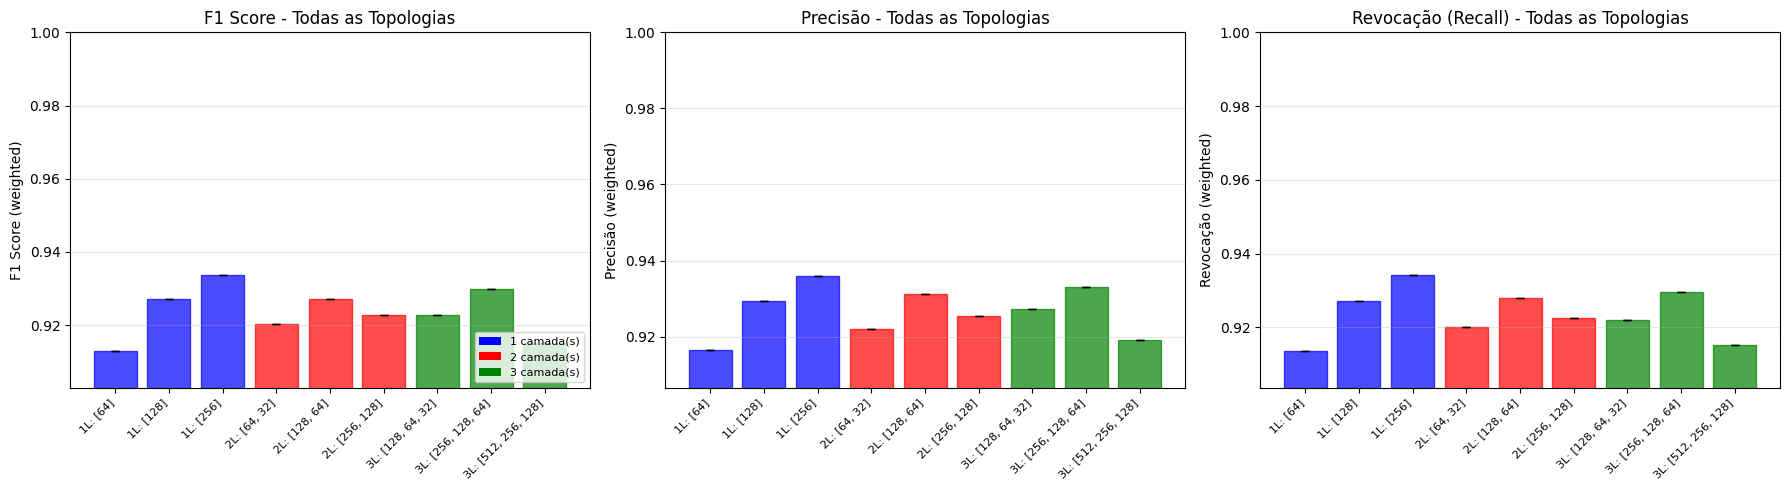


Métricas de Generalização:

1 camada(s):
  [64]:
    F1: 0.9129 (±0.0000)
    Precisão: 0.9166 (±0.0000)
    Revocação: 0.9136 (±0.0000)
  [128]:
    F1: 0.9270 (±0.0000)
    Precisão: 0.9295 (±0.0000)
    Revocação: 0.9272 (±0.0000)
  [256]:
    F1: 0.9336 (±0.0000)
    Precisão: 0.9360 (±0.0000)
    Revocação: 0.9341 (±0.0000)

2 camada(s):
  [64, 32]:
    F1: 0.9202 (±0.0000)
    Precisão: 0.9221 (±0.0000)
    Revocação: 0.9201 (±0.0000)
  [128, 64]:
    F1: 0.9272 (±0.0000)
    Precisão: 0.9311 (±0.0000)
    Revocação: 0.9280 (±0.0000)
  [256, 128]:
    F1: 0.9227 (±0.0000)
    Precisão: 0.9254 (±0.0000)
    Revocação: 0.9225 (±0.0000)

3 camada(s):
  [128, 64, 32]:
    F1: 0.9227 (±0.0000)
    Precisão: 0.9274 (±0.0000)
    Revocação: 0.9219 (±0.0000)
  [256, 128, 64]:
    F1: 0.9300 (±0.0000)
    Precisão: 0.9331 (±0.0000)
    Revocação: 0.9297 (±0.0000)
  [512, 256, 128]:
    F1: 0.9152 (±0.0000)
    Precisão: 0.9192 (±0.0000)
    Revocação: 0.9153 (±0.0000)

RESUMO - TOP 3 MEL

In [87]:
# Métricas da Questão 03: análise de todas as topologias testadas
# Métricas: função de perda, curva de convergência, tempo de treinamento, generalização (F1), precisão, revocação

print("========== ANÁLISE DE TODAS AS TOPOLOGIAS Q3 ==========\n")

# Organiza os resultados por número de camadas
results_by_layers = {}
for r in results_q3:
    nh = r['number of hidden layers']
    if nh not in results_by_layers:
        results_by_layers[nh] = []
    results_by_layers[nh].append(r)

# Ordena cada grupo por soma de neurônios
for nh in results_by_layers:
    results_by_layers[nh].sort(key=lambda x: sum(x['neurons per layer']))

colors_map = {1: 'blue', 2: 'red', 3: 'green'}
markers_map = {1: 'o', 2: 's', 3: '^'}

# Prepara dados agregados
all_configs = []
all_losses = []
all_loss_stds = []
all_accuracies = []
all_acc_stds = []
all_times = []
all_time_stds = []
all_f1 = []
all_f1_stds = []
all_precision = []
all_precision_stds = []
all_recall = []
all_recall_stds = []
colors_list = []

for nh in sorted(results_by_layers.keys()):
    for r in results_by_layers[nh]:
        config_label = f"{nh}L: {r['neurons per layer']}"
        all_configs.append(config_label)
        all_losses.append(r['loss_mean'])
        all_loss_stds.append(r['loss_std'])
        all_accuracies.append(r['accuracy_mean'])
        all_acc_stds.append(r['accuracy_std'])
        all_times.append(r['time_mean'])
        all_time_stds.append(r['time_std'])
        all_f1.append(r['f1_mean'])
        all_f1_stds.append(r['f1_std'])
        all_precision.append(r['precision_mean'])
        all_precision_stds.append(r['precision_std'])
        all_recall.append(r['recall_mean'])
        all_recall_stds.append(r['recall_std'])
        colors_list.append(colors_map[nh])

x_pos = np.arange(len(all_configs))

# Legenda comum
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors_map[nh], label=f'{nh} camada(s)') 
                   for nh in sorted(colors_map.keys())]

# ========== 1. FUNÇÃO DE PERDA - COMPARAÇÃO ==========
print("1. FUNÇÃO DE PERDA - Todas as configurações")
fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(x_pos, all_losses, yerr=all_loss_stds, alpha=0.7, capsize=3)
for i, bar in enumerate(bars):
    bar.set_color(colors_list[i])

ax.set_xticks(x_pos)
ax.set_xticklabels(all_configs, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Loss Médio')
ax.set_title('Função de Perda - Todas as Topologias')
ax.grid(True, alpha=0.3, axis='y')
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

for nh in sorted(results_by_layers.keys()):
    print(f"\n{nh} camada(s):")
    for r in results_by_layers[nh]:
        print(f"  {r['neurons per layer']}: Loss = {r['loss_mean']:.4f} (±{r['loss_std']:.4f})")

# ========== 2. CURVAS DE CONVERGÊNCIA (UNDERFITTING/OVERFITTING) ==========
print("\n2. CURVAS DE CONVERGÊNCIA - Análise de Under/Overfitting")

# Agrupa históricos por configuração
histories_by_config = {}
for h_dict in histories_q3:
    key = (h_dict['num_hidden_layers'], str(h_dict['neurons_per_layer']))
    if key not in histories_by_config:
        histories_by_config[key] = []
    histories_by_config[key].append(h_dict['history'])

# Plota uma amostra representativa (top 3 e bottom 3 configurações)
sample_configs = [sorted_results_q3[i] for i in [0, 1, 2, -3, -2, -1]]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, config in enumerate(sample_configs):
    nh = config['number of hidden layers']
    nn = config['neurons per layer']
    key = (nh, str(nn))
    
    if key in histories_by_config:
        ax = axes[idx]
        
        # Plota loss e accuracy no mesmo gráfico com eixos duplos
        ax2 = ax.twinx()
        
        for h in histories_by_config[key]:
            line1 = ax.plot(h.history['loss'], alpha=0.7, color='red', linewidth=1.5)
            line2 = ax2.plot(h.history['accuracy'], alpha=0.7, color='blue', linewidth=1.5)
        
        ax.set_xlabel('Época')
        ax.set_ylabel('Loss (entropia cruzada)', color='red')
        ax.tick_params(axis='y', labelcolor='red')
        ax2.set_ylabel('Accuracy', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        ax2.set_ylim([0, 1])
        
        rank = idx + 1 if idx < 3 else f"{len(sorted_results_q3) - (5 - idx)}"
        ax.set_title(f"#{rank}: {nh}L {nn}\n(Loss continua caindo + Acc estagnada = Overfitting)", fontsize=9)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== 3. TEMPO DE TREINAMENTO ==========
print("\n3. TEMPO DE TREINAMENTO")
fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(x_pos, all_times, yerr=all_time_stds, alpha=0.7, capsize=3)
for i, bar in enumerate(bars):
    bar.set_color(colors_list[i])

ax.set_xticks(x_pos)
ax.set_xticklabels(all_configs, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Tempo de Treinamento (segundos)')
ax.set_title('Tempo de Treinamento - Todas as Topologias')
ax.grid(True, alpha=0.3, axis='y')
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

for nh in sorted(results_by_layers.keys()):
    print(f"\n{nh} camada(s):")
    for r in results_by_layers[nh]:
        print(f"  {r['neurons per layer']}: Tempo = {r['time_mean']:.2f}s (±{r['time_std']:.2f}s)")

# ========== 4. GENERALIZAÇÃO (F1, PRECISÃO, REVOCAÇÃO) ==========
print("\n4. GENERALIZAÇÃO - Medida F1, Precisão e Revocação")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1 Score
bars0 = axes[0].bar(x_pos, all_f1, yerr=all_f1_stds, alpha=0.7, capsize=3)
for i, bar in enumerate(bars0):
    bar.set_color(colors_list[i])
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(all_configs, rotation=45, ha='right', fontsize=8)
axes[0].set_ylabel('F1 Score (weighted)')
axes[0].set_title('F1 Score - Todas as Topologias')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([min(all_f1) - 0.01, 1.0])
axes[0].legend(handles=legend_elements, loc='lower right', fontsize=8)

# Precisão
bars1 = axes[1].bar(x_pos, all_precision, yerr=all_precision_stds, alpha=0.7, capsize=3)
for i, bar in enumerate(bars1):
    bar.set_color(colors_list[i])
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(all_configs, rotation=45, ha='right', fontsize=8)
axes[1].set_ylabel('Precisão (weighted)')
axes[1].set_title('Precisão - Todas as Topologias')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([min(all_precision) - 0.01, 1.0])

# Revocação
bars2 = axes[2].bar(x_pos, all_recall, yerr=all_recall_stds, alpha=0.7, capsize=3)
for i, bar in enumerate(bars2):
    bar.set_color(colors_list[i])
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(all_configs, rotation=45, ha='right', fontsize=8)
axes[2].set_ylabel('Revocação (weighted)')
axes[2].set_title('Revocação (Recall) - Todas as Topologias')
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].set_ylim([min(all_recall) - 0.01, 1.0])

plt.tight_layout()
plt.show()

print("\nMétricas de Generalização:")
for nh in sorted(results_by_layers.keys()):
    print(f"\n{nh} camada(s):")
    for r in results_by_layers[nh]:
        print(f"  {r['neurons per layer']}:")
        print(f"    F1: {r['f1_mean']:.4f} (±{r['f1_std']:.4f})")
        print(f"    Precisão: {r['precision_mean']:.4f} (±{r['precision_std']:.4f})")
        print(f"    Revocação: {r['recall_mean']:.4f} (±{r['recall_std']:.4f})")

# ========== RESUMO FINAL ==========
print("\n" + "="*60)
print("RESUMO - TOP 3 MELHORES TOPOLOGIAS")
print("="*60)
for i, r in enumerate(sorted_results_q3[:3], 1):
    print(f"\n#{i}: {r['number of hidden layers']} camadas, {r['neurons per layer']}")
    print(f"  Loss: {r['loss_mean']:.4f} (±{r['loss_std']:.4f})")
    print(f"  Accuracy: {r['accuracy_mean']:.4f} (±{r['accuracy_std']:.4f})")
    print(f"  F1 Score: {r['f1_mean']:.4f} (±{r['f1_std']:.4f})")
    print(f"  Precisão: {r['precision_mean']:.4f} (±{r['precision_std']:.4f})")
    print(f"  Revocação: {r['recall_mean']:.4f} (±{r['recall_std']:.4f})")
    print(f"  Tempo: {r['time_mean']:.2f}s (±{r['time_std']:.2f}s)")

print("\n✓ Análise completa das métricas Q3 concluída")